In [1]:
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import cmasher as cmr
from easyquery import Query
import pickle

import treecorr

import shap
from interpret.glassbox import ExplainableBoostingRegressor

import cmasher as cmr
C0, C1, C2, C3 = cmr.take_cmap_colors('cmr.rainforest', 4, cmap_range=(0.8, 0.2), return_fmt='hex')


ROOT = Path("..").resolve()
tng_base_path = f"{ROOT}/illustris_data/TNG300-1/output"
results_base_path = f"{ROOT}/results/"

In [2]:
def rmse(p, y): return ((p-y)**2).mean()**0.5

def load_gnn_rmse_results(filepath, query=None, reduce_func=rmse, column="p_GNN_dmo_base"):
    """Returns the shape (3,) rmse results from k=3-fold validation
    for the experiment given by the filepath.

    By default loads the p_GNN_dmo_base column, but can also get others
    """
    df = pd.read_parquet(filepath)

    if query is not None:
        df = query.filter(df).copy()

    rmse_gnn_k = []
    for k in range(3):
        df_k = Query(f"k_fold == {k}").filter(df)
        rmse_gnn_k.append(reduce_func(df_k[column], df_k.log_Mstar))

    return np.array(rmse_gnn_k)

def print_results(results_array):
    print(f"{np.mean(results_array):.4f} +/- {np.std(results_array):.4f}")


# Collate results and train EBM

In [4]:
retrain_ebm = False

ebm_hyperparams = {
    "max_bins": 50000, 
    "validation_size": 0.3,
    "interactions": 32,
}

In [7]:
dmo_cols = ['log_Mstar', 'log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central', 'overdensity', 'd_minima', 'd_node', 'd_saddle_1', 'd_saddle_2', 'd_skel', 'k_fold', 'x_dmo', 'y_dmo', 'z_dmo', 'vx_dmo', 'vz_dmo']
# hydro_cols = ['log_Mstar', 'p_GNN_hydro', 'log_Mhalo_hydro', 'log_Vmax_hydro', 'is_central', 'overdensity', 'd_minima', 'd_node', 'd_saddle_1', 'd_saddle_2', 'd_skel', 'k_fold']

# these don't get updated
p_EBM_base = []
p_EBM_disperse = []
p_SHAM = []

# for D_link in [0.3, 1, 3, 10]:
for D_link in [0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 7.5, 10]:

    print(f"Working on {D_link} Mpc")
    df = pd.read_parquet(f"{results_base_path}/linking_length_tests/D_link{D_link}/cv-results.parquet")
    
    results = df[dmo_cols].copy()

    results["p_GNN_dmo"] = df['p_GNN_dmo']

    p_EBM_overdensity = []
    p_EBM_all = []
    
    sham_dmo_central_interp = lambda Vmax: np.interp(Vmax, *sham_dmo_central.T[::-1].T)
    sham_dmo_satellite_interp = lambda Vmax: np.interp(Vmax, *sham_dmo_satellite.T[::-1].T)
    sham_dmo_predictions = lambda Vmax, cen: np.where(cen, sham_dmo_central_interp(Vmax), sham_dmo_satellite_interp(Vmax))

    for k in range(3):

        train_mask = (df.k_fold != k)
        valid_mask = (df.k_fold == k)
        
        X_base = df[['log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central']]
        X_overdensity = df[['log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central', 'overdensity']]
        X_disperse = df[['log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central', 'd_minima', 'd_node', 'd_saddle_1', 'd_saddle_2', 'd_skel']]
        X_all = df[['log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central', 'overdensity', 'd_minima', 'd_node', 'd_saddle_1', 'd_saddle_2', 'd_skel']]
       
        X_train_base = X_base[train_mask]
        X_valid_base = X_base[valid_mask]
        X_train_all = X_all[train_mask]
        X_valid_all = X_all[valid_mask]
        X_train_disperse = X_disperse[train_mask]
        X_valid_disperse = X_disperse[valid_mask]
        X_train_all = X_all[train_mask]
        X_valid_all = X_all[valid_mask]

        y = df['log_Mstar']
        y_train = y[train_mask]
        y_valid = y[valid_mask]

        # EBM models filenames
        ebm_base_fname = f"{results_base_path}/linking_length_tests/D_link{D_link}/models/ebm_base-fold_{k}.pkl"
        ebm_overdensity_fname = f"{results_base_path}/linking_length_tests/D_link{D_link}/models/ebm_overdensity-fold_{k}.pkl"
        ebm_disperse_fname = f"{results_base_path}/linking_length_tests/D_link{D_link}/models/ebm_disperse-fold_{k}.pkl"
        ebm_all_fname = f"{results_base_path}/linking_length_tests/D_link{D_link}/models/ebm_all-fold_{k}.pkl"

        # SHAM - vmax
        if D_link == 0.3:
            sham_dmo_central = np.vstack([list(reversed(sorted((X_train_base.log_Vmax_dmo[X_train_base.is_central])))), list(reversed(sorted(y_train[X_train_base.is_central])))])
            sham_dmo_satellite = np.vstack([list(reversed(sorted((X_train_base.log_Vmax_dmo[~X_train_base.is_central])))), list(reversed(sorted(y_train[~X_train_base.is_central])))])        
            y_pred_sham = np.array([sham_dmo_predictions(Vmax, cen) for Vmax, cen in zip(X_valid_base.log_Vmax_dmo, X_valid_base.is_central)], dtype=float)
            p_SHAM += [y_pred_sham]
        

        # EBM - base
        if Path(ebm_base_fname).exists() and not retrain_ebm:
            with open(ebm_base_fname, "rb") as f:
                ebm_base = pickle.load(f)
            if D_link == 0.3:
                y_pred_base = ebm_base.predict(X_valid_base)
                p_EBM_base += [y_pred_base]
                
        else:
            # only needs to be trained and estimated the first time...
            if D_link == 0.3:
                ebm_base = ExplainableBoostingRegressor(**ebm_hyperparams)        
                ebm_base.fit(X_train_base, y_train)
                y_pred_base = ebm_base.predict(X_valid_base)
                p_EBM_base += [y_pred_base]
            with open(ebm_base_fname, "wb") as f: 
                pickle.dump(ebm_base, f)

        # EBM - overdensity
        if Path(ebm_overdensity_fname).exists() and not retrain_ebm:
            with open(ebm_overdensity_fname, "rb") as f:
                ebm_overdensity = pickle.load(f)
            y_pred_overdensity = ebm_overdensity.predict(X_valid_all)
            p_EBM_overdensity += [y_pred_overdensity]
        else:
            ebm_overdensity = ExplainableBoostingRegressor(**ebm_hyperparams)        
            ebm_overdensity.fit(X_train_overdensity, y_train)
            y_pred_overdensity = ebm_overdensity.predict(X_valid_overdensity)
            p_EBM_overdensity += [y_pred_overdensity]
            with open(ebm_overdensity_fname, "wb") as f: 
                pickle.dump(ebm_overdensity, f)

        # EBM - disperse
        if Path(ebm_disperse_fname).exists() and not retrain_ebm:
            with open(ebm_disperse_fname, "rb") as f:
                ebm_disperse = pickle.load(f)
            if D_link == 0.3:
                y_pred_disperse = ebm_disperse.predict(X_valid_disperse)
                p_EBM_disperse += [y_pred_disperse]
        else:
            # only needs to be trained and estimated the first time...
            if D_link == 0.3:
                ebm_disperse = ExplainableBoostingRegressor(**ebm_hyperparams)
                ebm_disperse.fit(X_train_disperse, y_train)
                y_pred_disperse = ebm_disperse.predict(X_valid_disperse)
                p_EBM_disperse += [y_pred_disperse]
            with open(ebm_disperse_fname, "wb") as f: 
                pickle.dump(ebm_disperse, f)

        # EBM - all
        if Path(ebm_all_fname).exists() and not retrain_ebm:
            with open(ebm_all_fname, "rb") as f:
                ebm_all = pickle.load(f)
            y_pred_all = ebm_all.predict(X_valid_all)
            p_EBM_all += [y_pred_all]
        else:
            ebm_all = ExplainableBoostingRegressor(**ebm_hyperparams)        
            ebm_all.fit(X_train_all, y_train)
            y_pred_all = ebm_all.predict(X_valid_all)
            p_EBM_all += [y_pred_all]
            with open(ebm_all_fname, "wb") as f: 
                pickle.dump(ebm_all, f)

    # save results!!!
    results["p_SHAM_vmax"] = np.concatenate(p_SHAM, axis=0)
    results["p_EBM_base"] = np.concatenate(p_EBM_base, axis=0)
    results["p_EBM_disperse"] = np.concatenate(p_EBM_disperse, axis=0)
    results["p_EBM_overdensity"] = np.concatenate(p_EBM_overdensity, axis=0)
    results["p_EBM_all"] = np.concatenate(p_EBM_all, axis=0)
    results.to_parquet(f"{results_base_path}/results-dmo_D_link{D_link}.parquet")


Working on 0.3 Mpc
Working on 0.5 Mpc
Working on 1 Mpc
Working on 1.5 Mpc
Working on 2 Mpc
Working on 2.5 Mpc
Working on 3 Mpc
Working on 3.5 Mpc
Working on 4 Mpc
Working on 5 Mpc
Working on 7.5 Mpc
Working on 10 Mpc


# Figure 2: Scatterplot of predictions at $D=3$ Mpc

In [3]:
df = pd.read_parquet(f"{results_base_path}/results-dmo_D_link3.parquet")

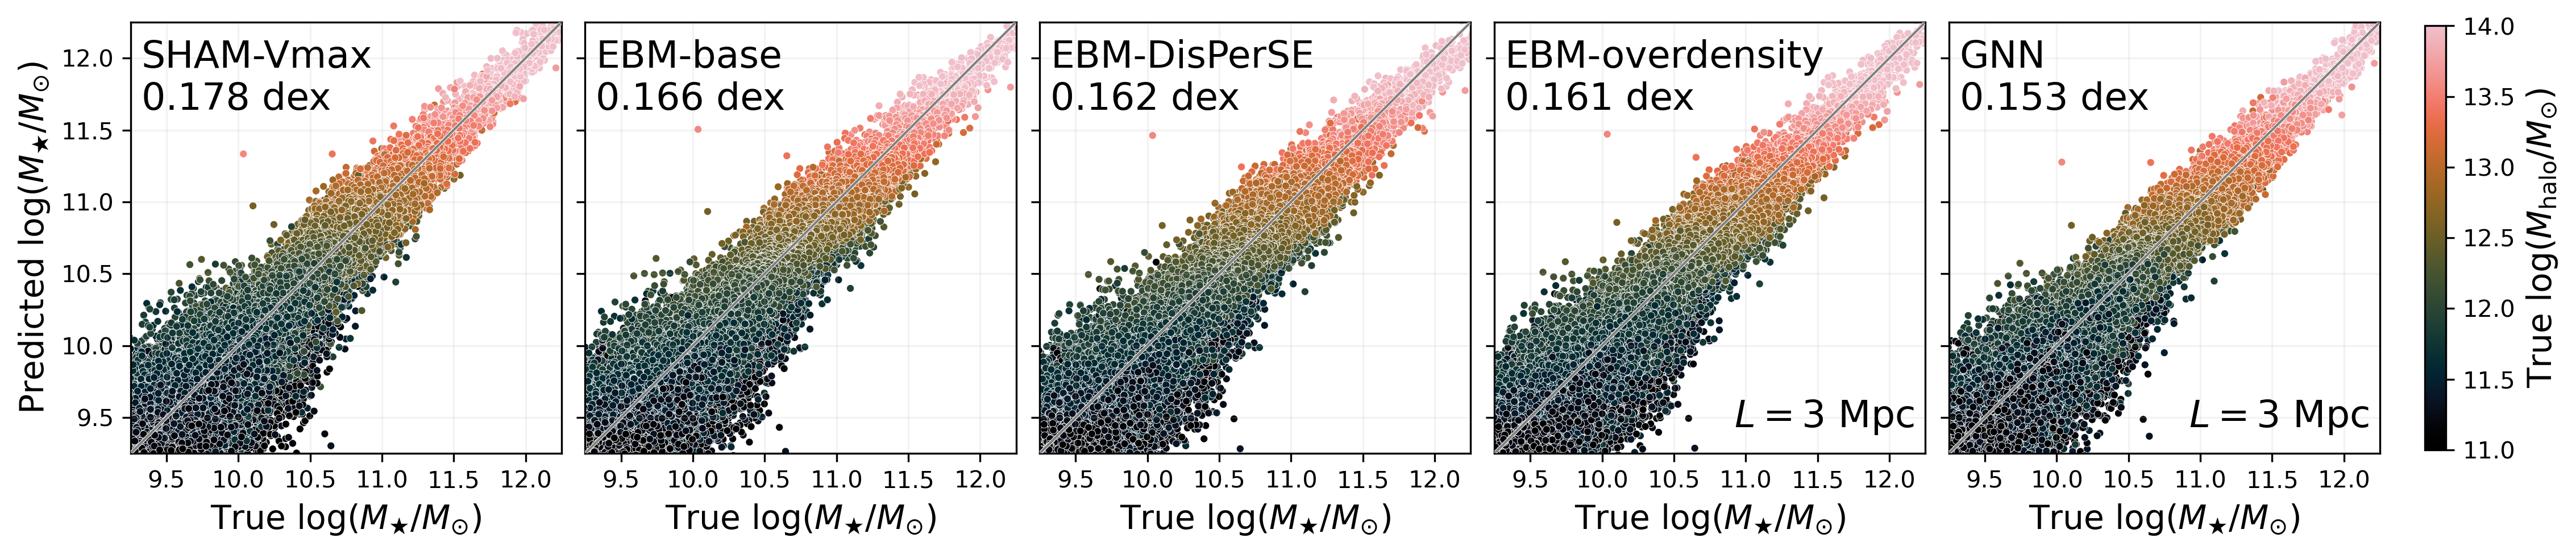

In [12]:
fig = plt.figure(figsize=(15, 3.2), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(1, 5, wspace=0.03, left=0.025, right=0.925, bottom=0.06, top=0.975, )
axes = gs.subplots(sharey="row")

ax1, ax2, ax3, ax4, ax5 = axes

ax1.scatter(df.log_Mstar, df.p_SHAM_vmax, c=df.log_Mhalo_dmo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14, rasterized=True)
ax1.text(0.025, 0.96, f"SHAM-Vmax\n{np.sqrt(np.mean((df.log_Mstar - df.p_SHAM_vmax)**2)):.3f} dex", va="top", transform=ax1.transAxes, fontsize=16)

ax2.scatter(df.log_Mstar, df.p_EBM_base, c=df.log_Mhalo_dmo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14, rasterized=True)
ax2.text(0.025, 0.96, f"EBM-base\n{np.sqrt(np.mean((df.log_Mstar - df.p_EBM_base)**2)):.3f} dex", va="top", transform=ax2.transAxes, fontsize=16)

ax3.scatter(df.log_Mstar, df.p_EBM_disperse, c=df.log_Mhalo_dmo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14, rasterized=True)
ax3.text(0.025, 0.96, f"EBM-DisPerSE\n{np.sqrt(np.mean((df.log_Mstar - df.p_EBM_disperse)**2)):.3f} dex", va="top", transform=ax3.transAxes, fontsize=16)

ax4.scatter(df.log_Mstar, df.p_EBM_overdensity, c=df.log_Mhalo_dmo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14, rasterized=True)
ax4.text(0.025, 0.96, f"EBM-overdensity\n{np.sqrt(np.mean((df.log_Mstar - df.p_EBM_overdensity)**2)):.3f} dex", va="top", transform=ax4.transAxes, fontsize=16)
ax4.text(0.975, 0.04, f"$L=3$ Mpc", va="bottom", ha="right", transform=ax4.transAxes, fontsize=16)

sc = ax5.scatter(df.log_Mstar, df.p_GNN_dmo, c=df.log_Mhalo_dmo, edgecolor='white', linewidths=0.2, s=10, cmap=cmr.dusk, vmin=11, vmax=14, rasterized=True)
ax5.text(0.025, 0.96, f"GNN\n{np.sqrt(np.mean((df.log_Mstar - df.p_GNN_dmo)**2)):.3f} dex", va="top", transform=ax5.transAxes, fontsize=16)
ax5.text(0.975, 0.04, f"$L=3$ Mpc", va="bottom", ha="right", transform=ax5.transAxes, fontsize=16)

cb = fig.colorbar(sc, ax=axes, pad=0.02, shrink=0.92)
cb.set_label("True log($M_{\\rm halo}/M_{\\odot}}$)", fontsize=14)


for ax in axes:
    ax.plot([0, 50], [0, 50], lw=1.5, c='w', zorder=9)
    ax.plot([0, 50], [0, 50], lw=1, c='0.5', zorder=10)
    ax.grid(alpha=0.15)
    ax.set_xlim(9.25, 12.25)
    ax.set_ylim(9.25, 12.25)
    ax.set_xticks([9.5, 10, 10.5, 11, 11.5, 12])
    ax.set_yticks([9.5, 10, 10.5, 11, 11.5, 12])

    if ax == axes[0]:
        ax.set_ylabel("Predicted log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=14)
    ax.set_xlabel("True log($M_{\\bigstar}/M_{\\odot}}$)", fontsize=14)
    ax.set_aspect("equal")

plt.savefig(f"{results_base_path}/losses-dmo-comparison.pdf")

# Figure 3: Linking Length results

In [4]:
# create a N_Dlinks x 3 array of results for the GNN base, base EBM, overdensity EBM, and disperse EBM
D_links = [0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 7.5, 10]
# D_links = [0.3, 1, 3, 10]
q = Query("log_Mstar > 9")

results_sham = np.empty((len(D_links), 3))
results_gnn = np.empty((len(D_links), 3))
results_ebm_base = np.empty((len(D_links), 3))
results_ebm_overdensity = np.empty((len(D_links), 3))
results_ebm_disperse = np.empty((len(D_links), 3))
results_ebm_all = np.empty((len(D_links), 3))


for i, D_link in enumerate(D_links):
    
    results_filepath = f"{results_base_path}/results-dmo_D_link{D_link}.parquet"

    results_sham[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_SHAM_vmax")
    results_gnn[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_GNN_dmo")
    results_ebm_base[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_EBM_base")
    results_ebm_overdensity[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_EBM_overdensity")
    results_ebm_disperse[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_EBM_disperse")
    results_ebm_all[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_EBM_all")

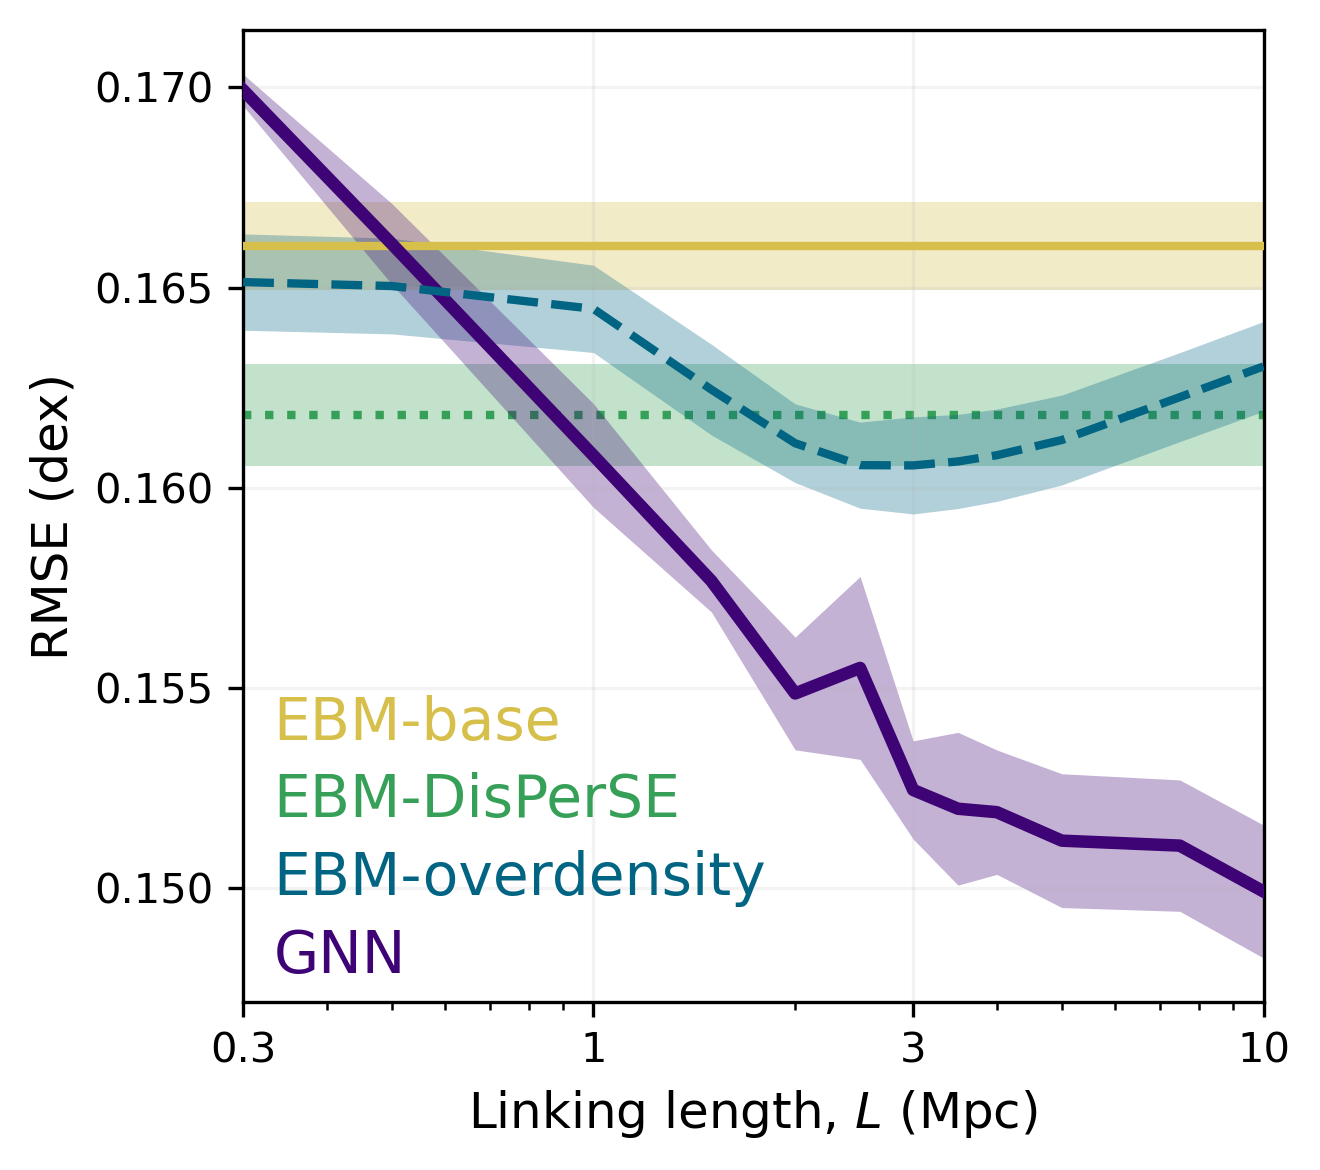

In [88]:
plt.figure(figsize=(4.5, 4.), dpi=300)

plt.plot(D_links, np.mean(results_ebm_base, 1), c=C0, lw=2, zorder=3)
plt.fill_between(D_links, np.mean(results_ebm_base, 1)-np.std(results_ebm_base, 1), np.mean(results_ebm_base, 1)+np.std(results_ebm_base, 1), color=C0, alpha=0.3, lw=0)

plt.axhline(np.mean(results_ebm_disperse), c=C1, lw=2, ls=":", zorder=1)
plt.axhspan(np.mean(results_ebm_disperse)-np.std(results_ebm_disperse), np.mean(results_ebm_disperse)+np.std(results_ebm_disperse), color=C1, lw=0, alpha=0.3, zorder=1)

plt.plot(D_links, np.mean(results_ebm_overdensity, 1), c=C2, lw=2, ls="--", zorder=4)
plt.fill_between(D_links, np.mean(results_ebm_overdensity, 1)-np.std(results_ebm_overdensity, 1), np.mean(results_ebm_overdensity, 1)+np.std(results_ebm_overdensity, 1), color=C2, alpha=0.3, lw=0)

# plt.plot(D_links, np.mean(results_ebm_all, 1), c=C3, lw=2, zorder=3)
# plt.fill_between(D_links, np.mean(results_ebm_all, 1)-np.std(results_ebm_all, 1), np.mean(results_ebm_all, 1)+np.std(results_ebm_all, 1), color=C3, alpha=0.3, lw=0)

plt.plot(D_links, np.mean(results_gnn, 1), c=C3, lw=3, zorder=3)
plt.fill_between(D_links, np.mean(results_gnn, 1)-np.std(results_gnn, 1), np.mean(results_gnn, 1)+np.std(results_gnn, 1), color=C3, alpha=0.3, lw=0)


plt.text(0.03, 0.27, "EBM-base", ha="left", transform=plt.gca().transAxes, fontsize=14, color=C0)
plt.text(0.03, 0.19, "EBM-DisPerSE", ha="left", transform=plt.gca().transAxes, fontsize=14, color=C1)
plt.text(0.03, 0.11, "EBM-overdensity", ha="left", transform=plt.gca().transAxes, fontsize=14, color=C2)
plt.text(0.03, 0.03, "GNN", ha="left", transform=plt.gca().transAxes, fontsize=14, color=C3)

plt.xscale("log")
plt.xticks(ticks=[0.3, 1, 3, 10], labels=[0.3, 1, 3, 10])
plt.grid(alpha=0.15)
plt.xlabel("Linking length, $L$ (Mpc)", fontsize=12)
plt.ylabel("RMSE (dex)", fontsize=12)
plt.xlim(0.3, 10)
plt.tight_layout()

# plt.savefig(f"{results_base_path}/GNN-EBM-linking_length-comparison.pdf")

# Table 1

In [23]:
print(f"SHAM Vmax RMSE= {np.mean(results_sham[0]):.4f} +/- {np.std(results_sham[0]):.4f}")

print(f"EBM-base RMSE = {np.mean(results_ebm_base[0]):.4f} +/- {np.std(results_ebm_base[0]):.4f}")

print(f"EBM-DisPerSE RMSE = {np.mean(results_ebm_disperse[0]):.4f} +/- {np.std(results_ebm_disperse[0]):.4f}")

idx_ebm_overdensity = np.argmin(np.mean(results_ebm_overdensity, 1))
print(
    f"EBM-overdensity RMSE = {np.mean(results_ebm_overdensity[idx_ebm_overdensity]):.4f} +/- {np.std(results_ebm_overdensity[idx_ebm_overdensity]):.4f}; "
    + f"D_link = {D_links[idx_ebm_overdensity]} Mpc"
)

idx_ebm_all = np.argmin(np.mean(results_ebm_all, 1))
print(
    f"EBM-all RMSE = {np.mean(results_ebm_all[idx_ebm_all]):.4f} +/- {np.std(results_ebm_all[idx_ebm_all]):.4f}; "
    + f"D_link = {D_links[idx_ebm_all]} Mpc"
)

idx_ebm_gnn = np.argmin(np.mean(results_gnn, 1))
print(
    f"GNN RMSE = {np.mean(results_gnn[idx_ebm_gnn]):.4f} +/- {np.std(results_gnn[idx_ebm_gnn]):.4f}; "
    + f"D_link = {D_links[idx_ebm_gnn]} Mpc"
)

SHAM Vmax RMSE= 0.1779 +/- 0.0007
EBM-base RMSE = 0.1660 +/- 0.0011
EBM-DisPerSE RMSE = 0.1618 +/- 0.0013
EBM-overdensity RMSE = 0.1606 +/- 0.0012; D_link = 3 Mpc
EBM-all RMSE = 0.1596 +/- 0.0012; D_link = 2.5 Mpc
GNN RMSE = 0.1499 +/- 0.0017; D_link = 10 Mpc


In [65]:
print(
    f"GNN RMSE = {np.mean(results_gnn[idx_ebm_overdensity]):.4f} +/- {np.std(results_gnn[idx_ebm_overdensity]):.4f} at "
    + f"D_link = {D_links[idx_ebm_overdensity]} Mpc"
)

GNN RMSE = 0.1525 +/- 0.0012 at D_link = 3 Mpc


# Appendix Split results across halo mass bins (above and below 12)

EBM-overdensity RMSE = 0.1721 +/- 0.0012; D_link = 3 Mpc for M_h < 12
EBM-overdensity RMSE = 0.1184 +/- 0.0012; D_link = 3.5 Mpc for M_h >= 12


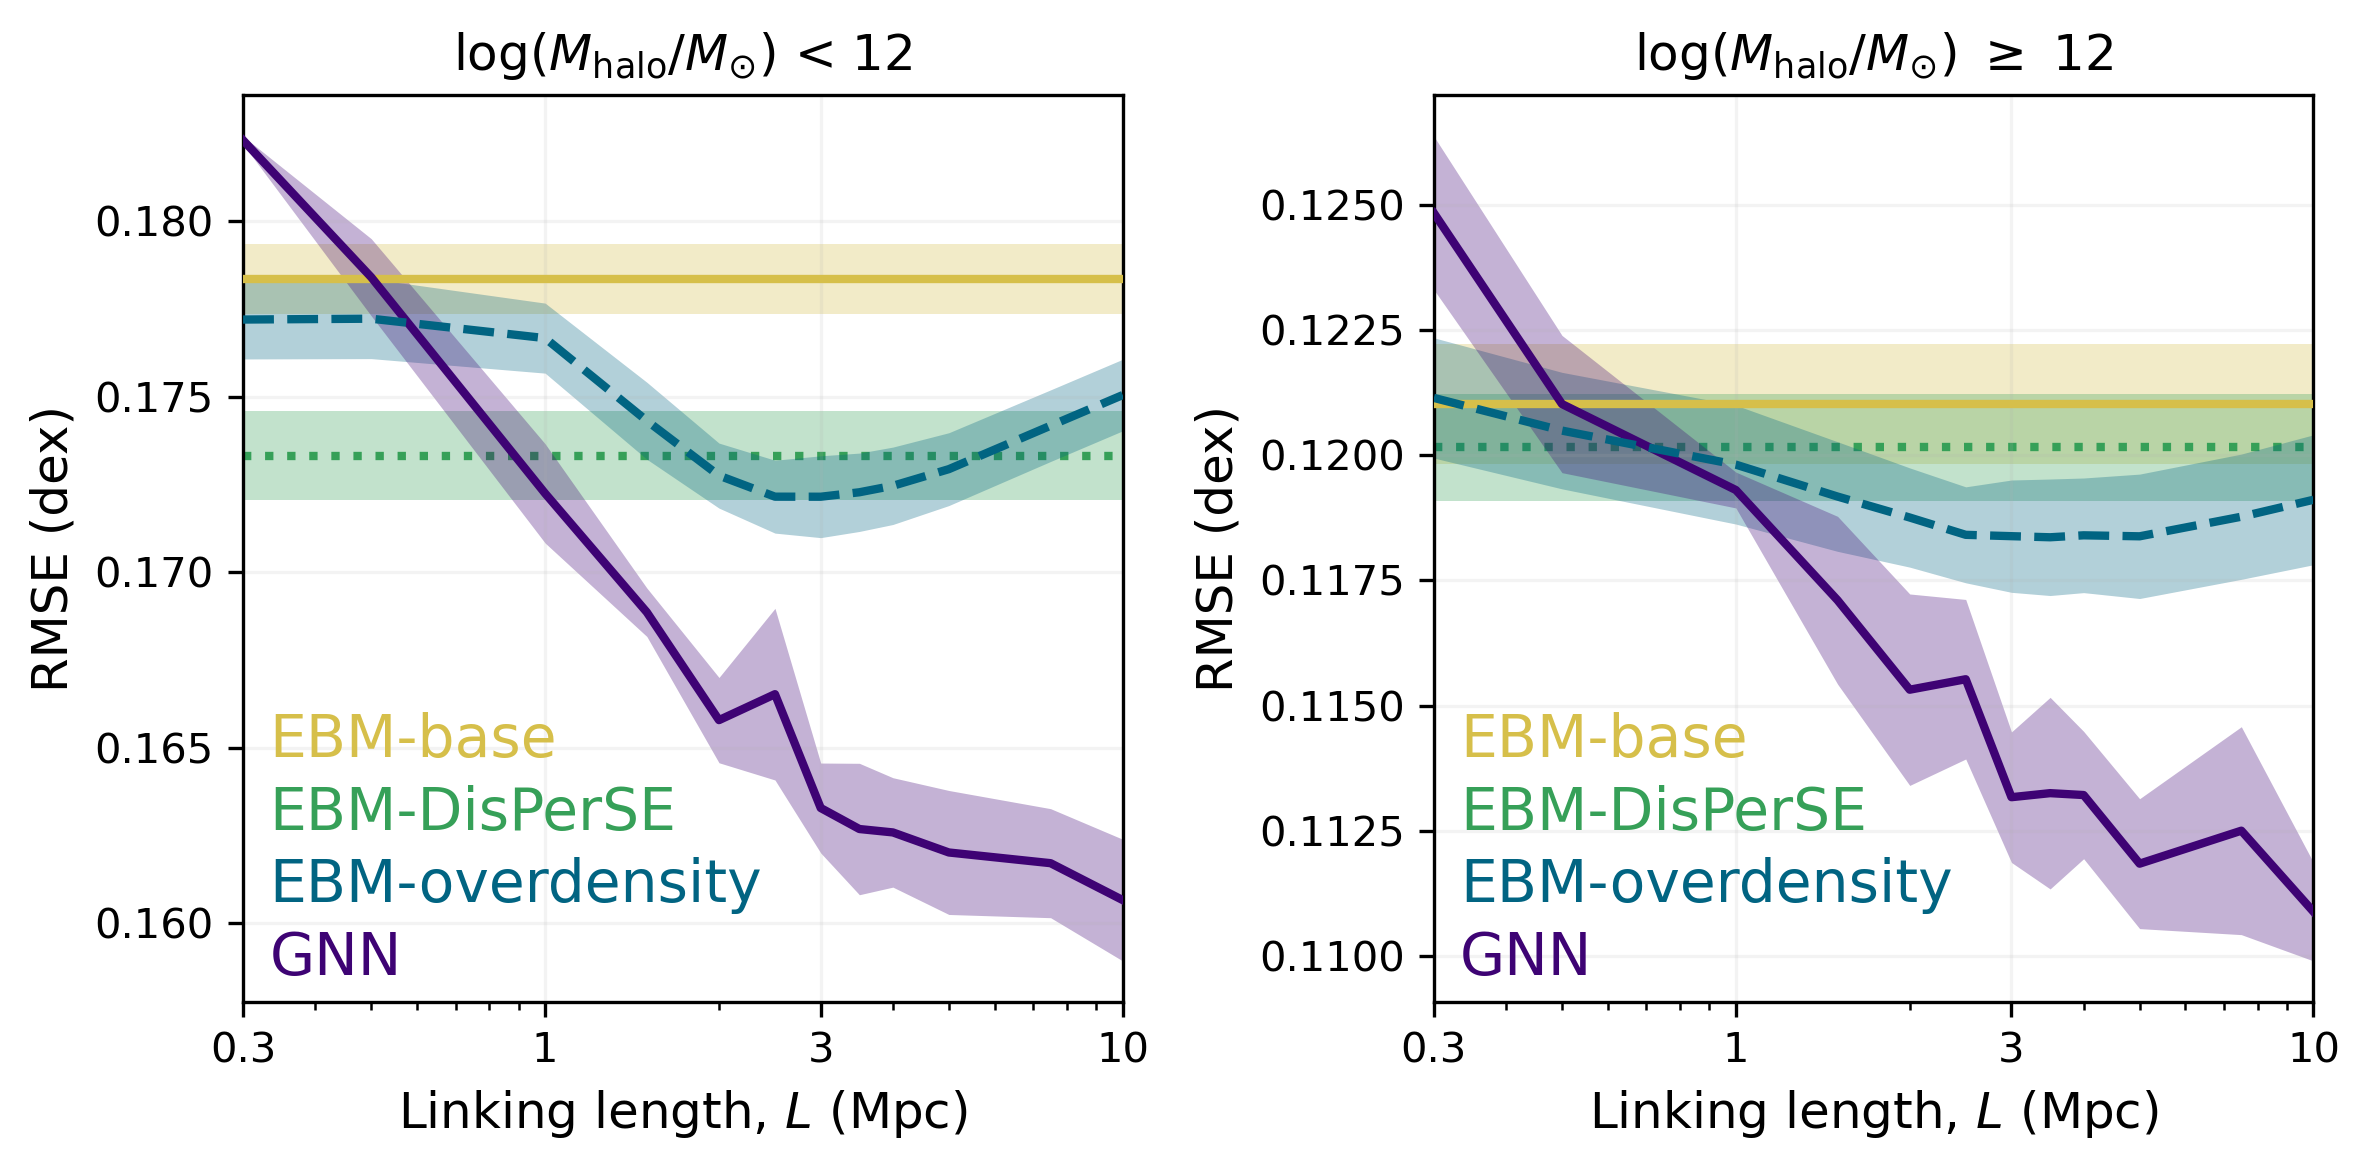

In [8]:
D_links = [0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 7.5, 10]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4.), dpi=300, sharey=False)

for ax, q_string in zip([ax1, ax2], ["< 12", ">= 12"]):
    q = Query("log_Mstar > 9", f"log_Mhalo_dmo {q_string}")

    results_gnn = np.empty((len(D_links), 3))
    results_ebm_base = np.empty((len(D_links), 3))
    results_ebm_overdensity = np.empty((len(D_links), 3))
    results_ebm_disperse = np.empty((len(D_links), 3))

    for i, D_link in enumerate(D_links):
        
        results_filepath = f"{results_base_path}/results-dmo_D_link{D_link}.parquet"

        results_gnn[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_GNN_dmo")
        results_ebm_base[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_EBM_base")
        results_ebm_overdensity[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_EBM_overdensity")
        results_ebm_disperse[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_EBM_disperse")

    ax.plot(D_links, np.mean(results_ebm_base, 1), c=C0, lw=2, zorder=3)
    ax.fill_between(D_links, np.mean(results_ebm_base, 1)-np.std(results_ebm_base, 1), np.mean(results_ebm_base, 1)+np.std(results_ebm_base, 1), color=C0, alpha=0.3, lw=0)

    ax.axhline(np.mean(results_ebm_disperse), c=C1, lw=2, ls=":", zorder=1)
    ax.axhspan(np.mean(results_ebm_disperse)-np.std(results_ebm_disperse), np.mean(results_ebm_disperse)+np.std(results_ebm_disperse), color=C1, lw=0, alpha=0.3, zorder=1)

    ax.plot(D_links, np.mean(results_ebm_overdensity, 1), c=C2, lw=2, ls="--", zorder=4)
    ax.fill_between(D_links, np.mean(results_ebm_overdensity, 1)-np.std(results_ebm_overdensity, 1), np.mean(results_ebm_overdensity, 1)+np.std(results_ebm_overdensity, 1), color=C2, alpha=0.3, lw=0)

    ax.plot(D_links, np.mean(results_gnn, 1), c=C3, lw=2, zorder=3)
    ax.fill_between(D_links, np.mean(results_gnn, 1)-np.std(results_gnn, 1), np.mean(results_gnn, 1)+np.std(results_gnn, 1), color=C3, alpha=0.3, lw=0)


    ax.text(0.03, 0.27, "EBM-base", ha="left", transform=ax.transAxes, fontsize=14, color=C0)
    ax.text(0.03, 0.19, "EBM-DisPerSE", ha="left", transform=ax.transAxes, fontsize=14, color=C1)
    ax.text(0.03, 0.11, "EBM-overdensity", ha="left", transform=ax.transAxes, fontsize=14, color=C2)
    ax.text(0.03, 0.03, "GNN", ha="left", transform=ax.transAxes, fontsize=14, color=C3)

    ax.set_xscale("log")
    ax.set_xticks(ticks=[0.3, 1, 3, 10], labels=[0.3, 1, 3, 10])
    ax.grid(alpha=0.15)
    ax.set_xlabel("Linking length, $L$ (Mpc)", fontsize=12)
    # plt.ylim(0.171, 0.181)
    ax.set_xlim(0.3, 10)
    ax.set_ylabel("RMSE (dex)", fontsize=12)
    ax.set_title("log$(M_{\\rm halo}/M_{\\odot})$" + f" {q_string}".replace(">=", "$\\geq$"))

    idx_ebm_overdensity = np.argmin(np.mean(results_ebm_overdensity, 1))
    print(
        f"EBM-overdensity RMSE = {np.mean(results_ebm_overdensity[idx_ebm_overdensity]):.4f} +/- {np.std(results_ebm_overdensity[idx_ebm_overdensity]):.4f}; "
        + f"D_link = {D_links[idx_ebm_overdensity]} Mpc "
        + f"for M_h {q_string}"
    )

plt.tight_layout()
plt.savefig(f"{results_base_path}/linking-length_split-by-mass.pdf")

# Appendix A: Split by central

EBM-overdensity RMSE = 0.2052 +/- 0.0002; D_link = 2.5 Mpc for M_h >= 12
EBM-overdensity RMSE = 0.1443 +/- 0.0009; D_link = 3.5 Mpc for M_h >= 12


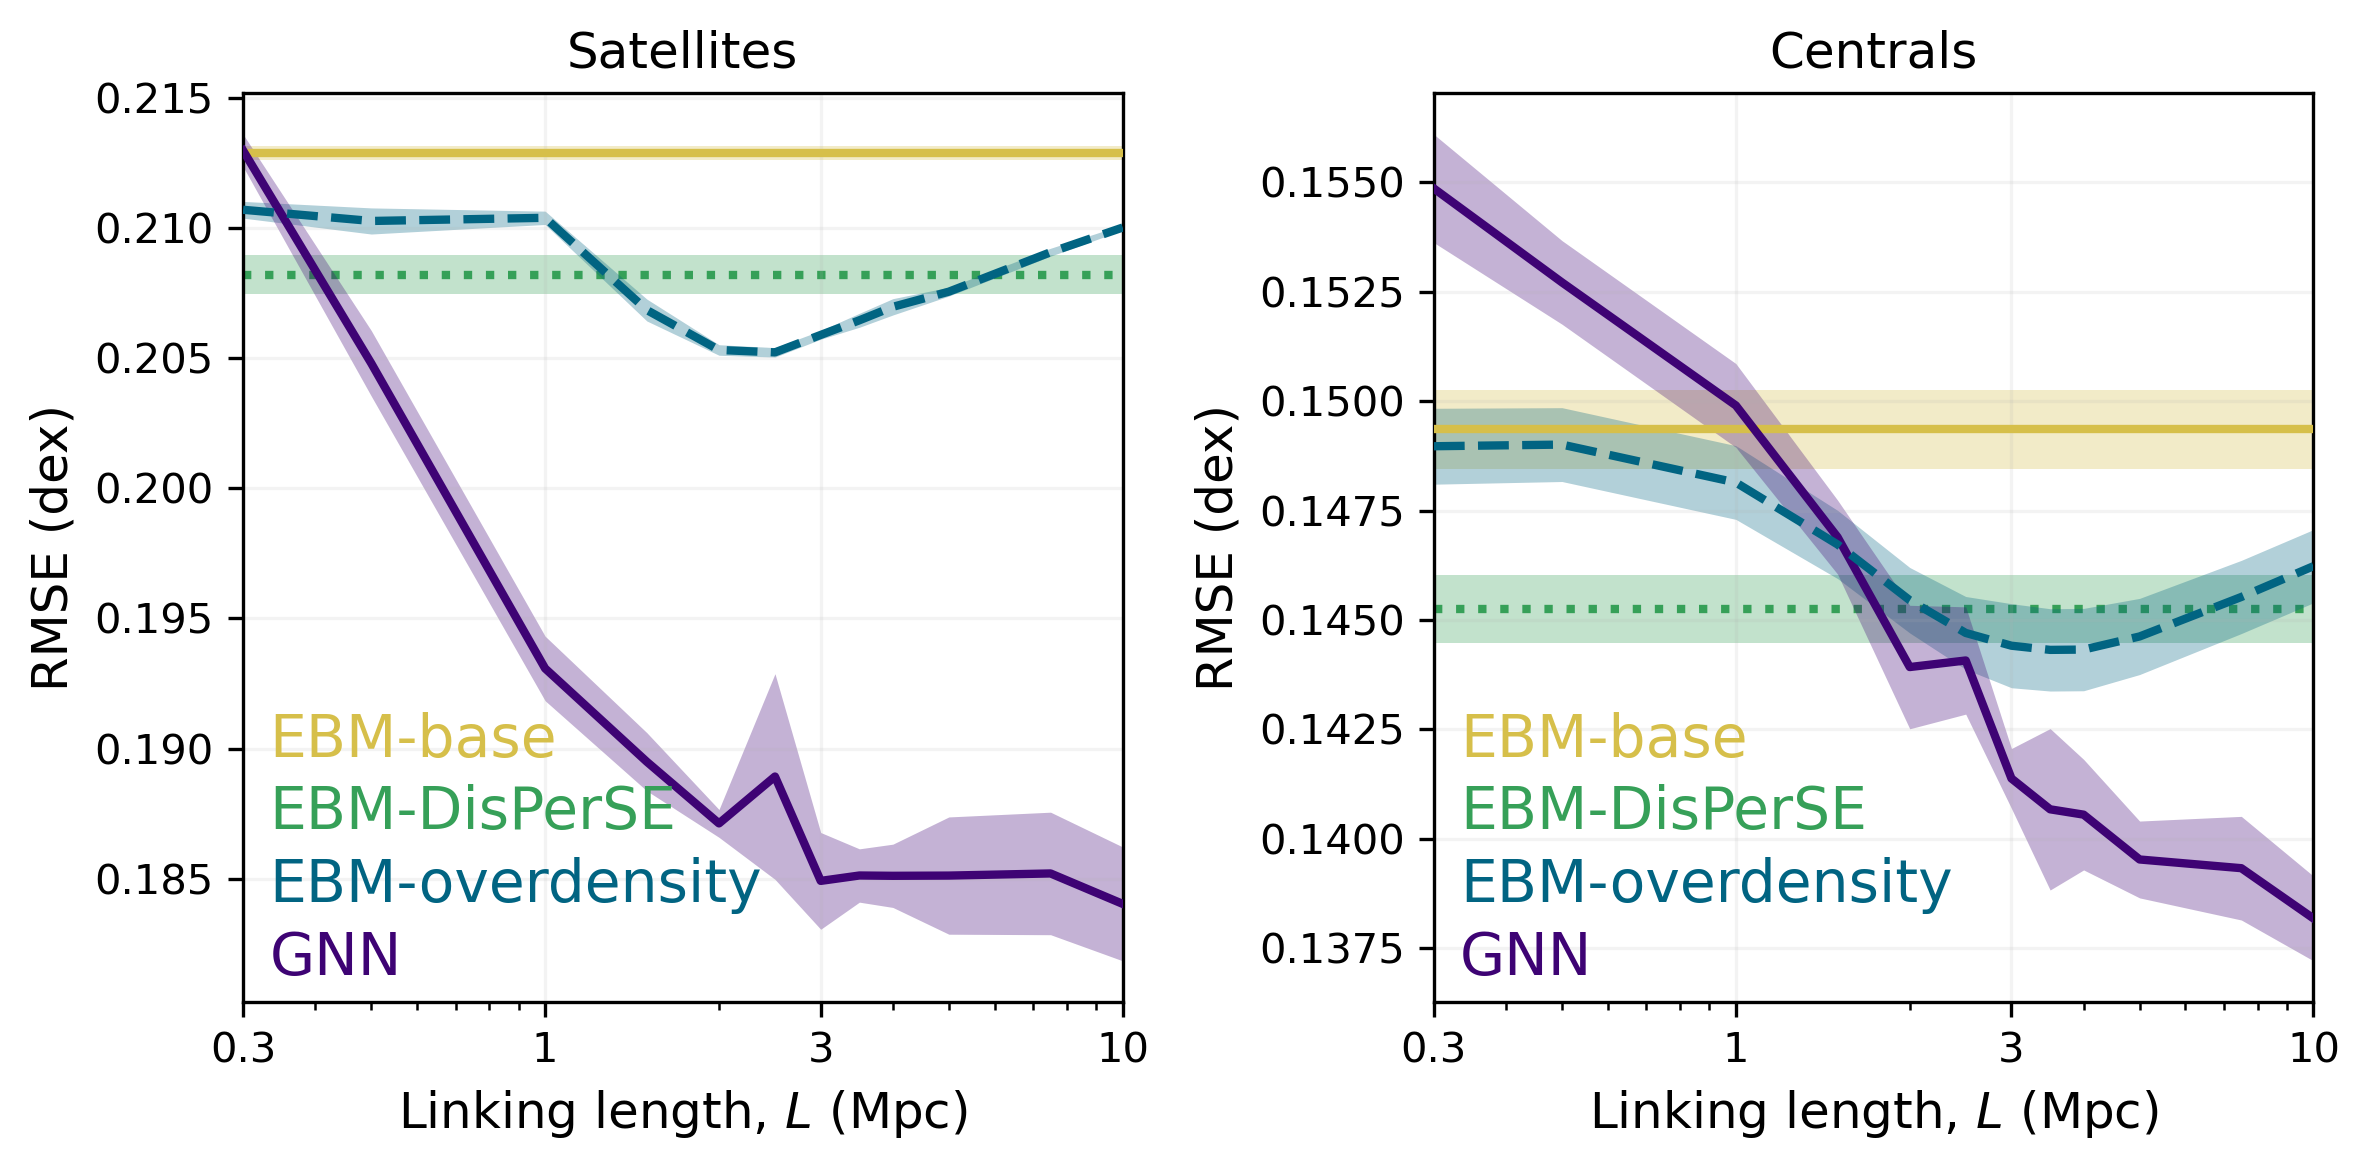

In [6]:
D_links = [0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 7.5, 10]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4.), dpi=300, sharey=False)

for ax, cen in zip([ax1, ax2], [False, True]):
    q = Query("log_Mstar > 9", f"is_central == {str(cen)}")

    results_gnn = np.empty((len(D_links), 3))
    results_ebm_base = np.empty((len(D_links), 3))
    results_ebm_overdensity = np.empty((len(D_links), 3))
    results_ebm_disperse = np.empty((len(D_links), 3))

    for i, D_link in enumerate(D_links):
        
        results_filepath = f"{results_base_path}/results-dmo_D_link{D_link}.parquet"

        results_gnn[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_GNN_dmo")
        results_ebm_base[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_EBM_base")
        results_ebm_overdensity[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_EBM_overdensity")
        results_ebm_disperse[i] = load_gnn_rmse_results(results_filepath, query=q, column="p_EBM_disperse")

    ax.plot(D_links, np.mean(results_ebm_base, 1), c=C0, lw=2, zorder=3)
    ax.fill_between(D_links, np.mean(results_ebm_base, 1)-np.std(results_ebm_base, 1), np.mean(results_ebm_base, 1)+np.std(results_ebm_base, 1), color=C0, alpha=0.3, lw=0)

    ax.axhline(np.mean(results_ebm_disperse), c=C1, lw=2, ls=":", zorder=1)
    ax.axhspan(np.mean(results_ebm_disperse)-np.std(results_ebm_disperse), np.mean(results_ebm_disperse)+np.std(results_ebm_disperse), color=C1, lw=0, alpha=0.3, zorder=1)

    ax.plot(D_links, np.mean(results_ebm_overdensity, 1), c=C2, lw=2, ls="--", zorder=4)
    ax.fill_between(D_links, np.mean(results_ebm_overdensity, 1)-np.std(results_ebm_overdensity, 1), np.mean(results_ebm_overdensity, 1)+np.std(results_ebm_overdensity, 1), color=C2, alpha=0.3, lw=0)

    ax.plot(D_links, np.mean(results_gnn, 1), c=C3, lw=2, zorder=3)
    ax.fill_between(D_links, np.mean(results_gnn, 1)-np.std(results_gnn, 1), np.mean(results_gnn, 1)+np.std(results_gnn, 1), color=C3, alpha=0.3, lw=0)


    ax.text(0.03, 0.27, "EBM-base", ha="left", transform=ax.transAxes, fontsize=14, color=C0)
    ax.text(0.03, 0.19, "EBM-DisPerSE", ha="left", transform=ax.transAxes, fontsize=14, color=C1)
    ax.text(0.03, 0.11, "EBM-overdensity", ha="left", transform=ax.transAxes, fontsize=14, color=C2)
    ax.text(0.03, 0.03, "GNN", ha="left", transform=ax.transAxes, fontsize=14, color=C3)

    ax.set_xscale("log")
    ax.set_xticks(ticks=[0.3, 1, 3, 10], labels=[0.3, 1, 3, 10])
    ax.grid(alpha=0.15)
    ax.set_xlabel("Linking length, $L$ (Mpc)", fontsize=12)
    # plt.ylim(0.171, 0.181)
    ax.set_xlim(0.3, 10)
    ax.set_ylabel("RMSE (dex)", fontsize=12)
    ax.set_title("Centrals" if cen else "Satellites")

    idx_ebm_overdensity = np.argmin(np.mean(results_ebm_overdensity, 1))
    print(
        f"EBM-overdensity RMSE = {np.mean(results_ebm_overdensity[idx_ebm_overdensity]):.4f} +/- {np.std(results_ebm_overdensity[idx_ebm_overdensity]):.4f}; "
        + f"D_link = {D_links[idx_ebm_overdensity]} Mpc "
        + f"for M_h {q_string}"
    )

plt.tight_layout()
plt.savefig(f"{results_base_path}/linking-length_split-by-centrals.pdf")

# Figure 3: Interpreting the EBM

In [83]:
D_link = 3
k = 1

df = pd.read_parquet(f"{results_base_path}/results-dmo_D_link{D_link}.parquet")
df["is_central"] = df["is_central"].astype(int)

X_base = df[['log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central']]
X_overdensity = df[['log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central', 'overdensity']]
X_disperse = df[['log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central', 'd_minima', 'd_node', 'd_saddle_1', 'd_saddle_2', 'd_skel']]
X_all = df[['log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central', 'overdensity', 'd_minima', 'd_node', 'd_saddle_1', 'd_saddle_2', 'd_skel']]

ebm_base_fname = f"{results_base_path}/linking_length_tests/D_link{D_link}/models/ebm_base-fold_{k}.pkl"
ebm_disperse_fname = f"{results_base_path}/linking_length_tests/D_link{D_link}/models/ebm_disperse-fold_{k}.pkl"
ebm_overdensity_fname = f"{results_base_path}/linking_length_tests/D_link{D_link}/models/ebm_overdensity-fold_{k}.pkl"
ebm_all_fname = f"{results_base_path}/linking_length_tests/D_link{D_link}/models/ebm_all-fold_{k}.pkl"

X_base_sample = X_base.sample(5000, replace=False, random_state=42)
X_disperse_sample = X_disperse.sample(5000, replace=False, random_state=42)
X_overdensity_sample = X_overdensity.sample(5000, replace=False, random_state=42)
X_all_sample = X_all.sample(5000, replace=False, random_state=42)

with open(ebm_base_fname, "rb") as f:
    ebm_base = pickle.load(f)

with open(ebm_disperse_fname, "rb") as f:
    ebm_disperse = pickle.load(f)

with open(ebm_overdensity_fname, "rb") as f:
    ebm_overdensity = pickle.load(f)

with open(ebm_all_fname, "rb") as f:
    ebm_all = pickle.load(f)

## EBM-base

In [37]:
explainer_ebm_base = shap.Explainer(ebm_base.predict, X_base_sample)
shap_ebm_base = explainer_ebm_base(X_base_sample)

with open(f"{results_base_path}/linking_length_tests/D_link{D_link}/models/shap_ebm_base-fold_{k}.pkl", "wb") as f:
    pickle.dump(shap_ebm_base, f)

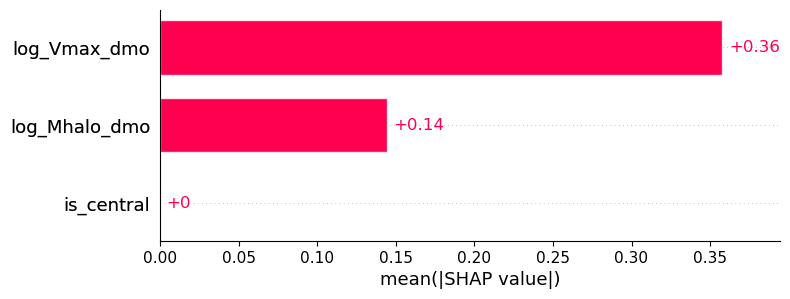

In [38]:
shap.plots.bar(shap_ebm_base)

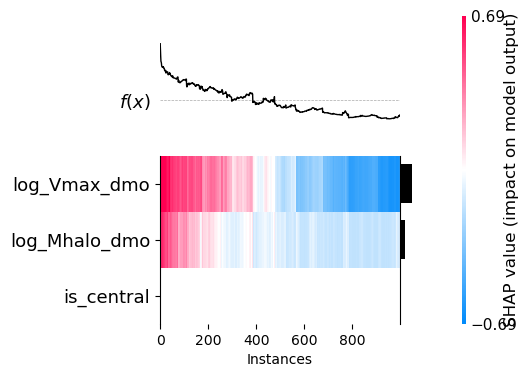

In [39]:
shap.plots.heatmap(shap_ebm_base[:1000])

## EBM-DisPerSE

In [40]:
explainer_ebm_disperse = shap.Explainer(ebm_disperse.predict, X_disperse_sample)
shap_ebm_disperse = explainer_ebm_disperse(X_disperse_sample)

with open(f"{results_base_path}/linking_length_tests/D_link{D_link}/models/shap_ebm_disperse-fold_{k}.pkl", "wb") as f:
    pickle.dump(shap_ebm_disperse, f)

ExactExplainer explainer: 5001it [01:12, 59.58it/s]                          


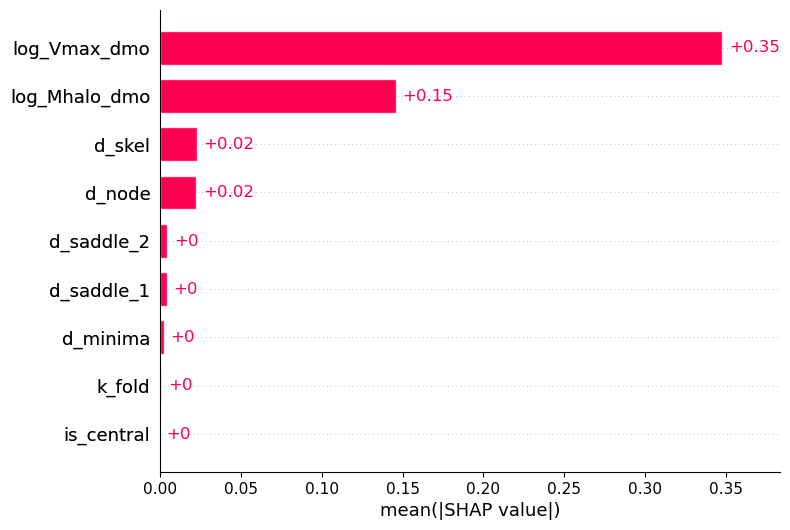

In [41]:
shap.plots.bar(shap_ebm_disperse)

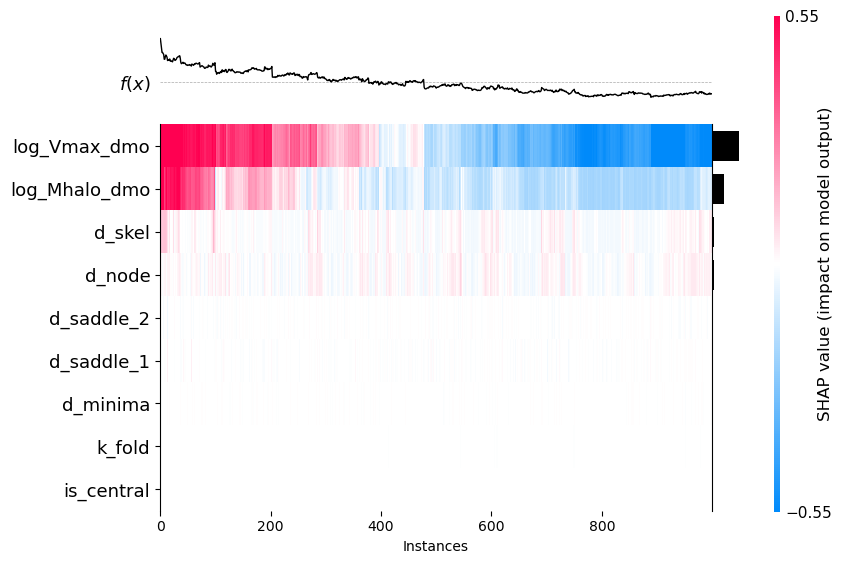

In [42]:
shap.plots.heatmap(shap_ebm_disperse[:1000])

## EBM-overdensity

In [46]:
explainer_ebm_overdensity = shap.Explainer(ebm_overdensity.predict, X_overdensity_sample)
shap_ebm_overdensity = explainer_ebm_overdensity(X_overdensity_sample)

with open(f"{results_base_path}/linking_length_tests/D_link{D_link}/models/shap_ebm_overdensity-fold_{k}.pkl", "wb") as f:
    pickle.dump(shap_ebm_overdensity, f)

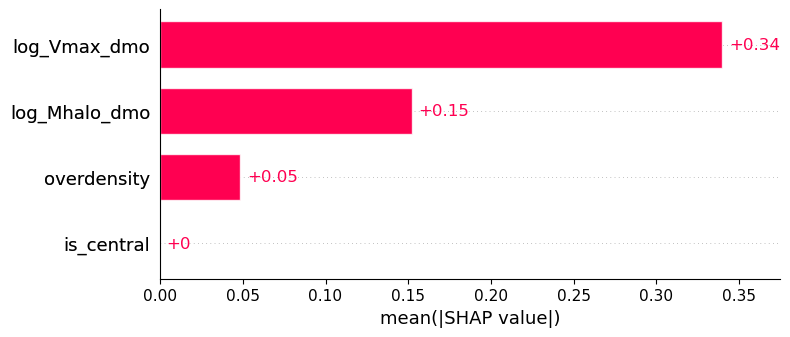

In [47]:
shap.plots.bar(shap_ebm_overdensity)

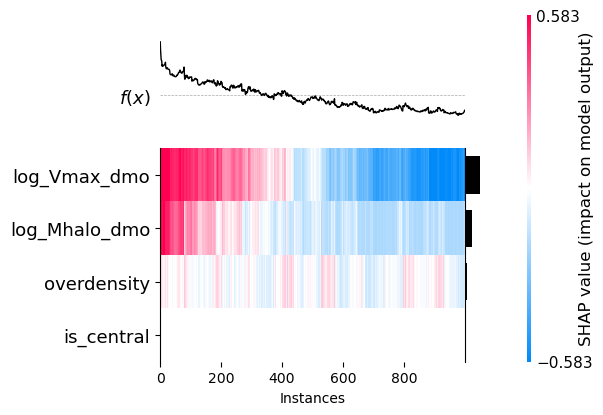

In [48]:
shap.plots.heatmap(shap_ebm_overdensity[:1000])

## EBM-all

In [4]:
# explainer_ebm_all = shap.Explainer(ebm_all.predict, X_all_sample)
# shap_ebm_all = explainer_ebm_all(X_all_sample)

# with open(f"{results_base_path}/linking_length_tests/D_link{D_link}/models/shap_ebm_all-fold_{k}.pkl", "wb") as f:
#     pickle.dump(shap_ebm_all, f)

with open(f"{results_base_path}/linking_length_tests/D_link{D_link}/models/shap_ebm_all-fold_{k}.pkl", "rb") as f:
    shap_ebm_all = pickle.load(f)

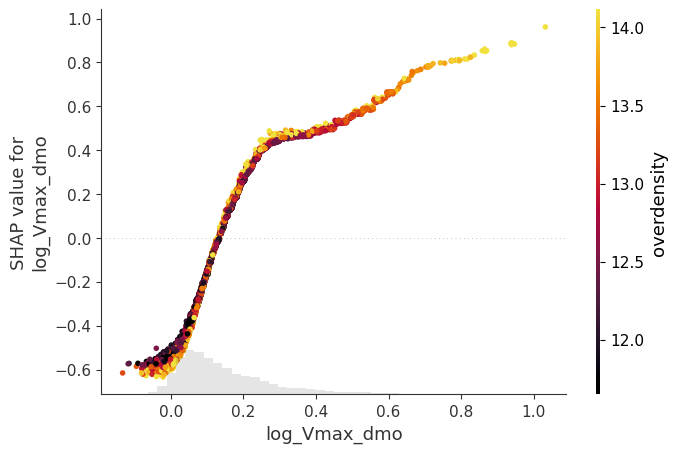

In [6]:
shap.plots.scatter(shap_ebm_all[:, "log_Vmax_dmo"], color=shap_ebm_all[:, "overdensity"], cmap=cmr.ember)

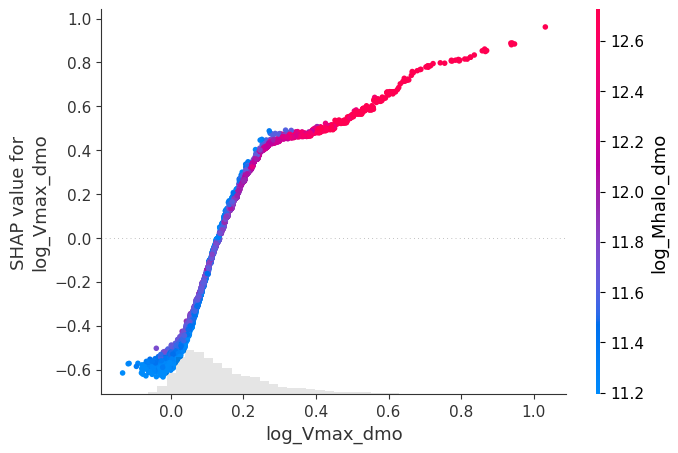

In [ ]:
shap.plots.scatter(shap_ebm_all[:, "log_Vmax_dmo"], color=shap_ebm_all[:, "log_Mhalo_dmo"])

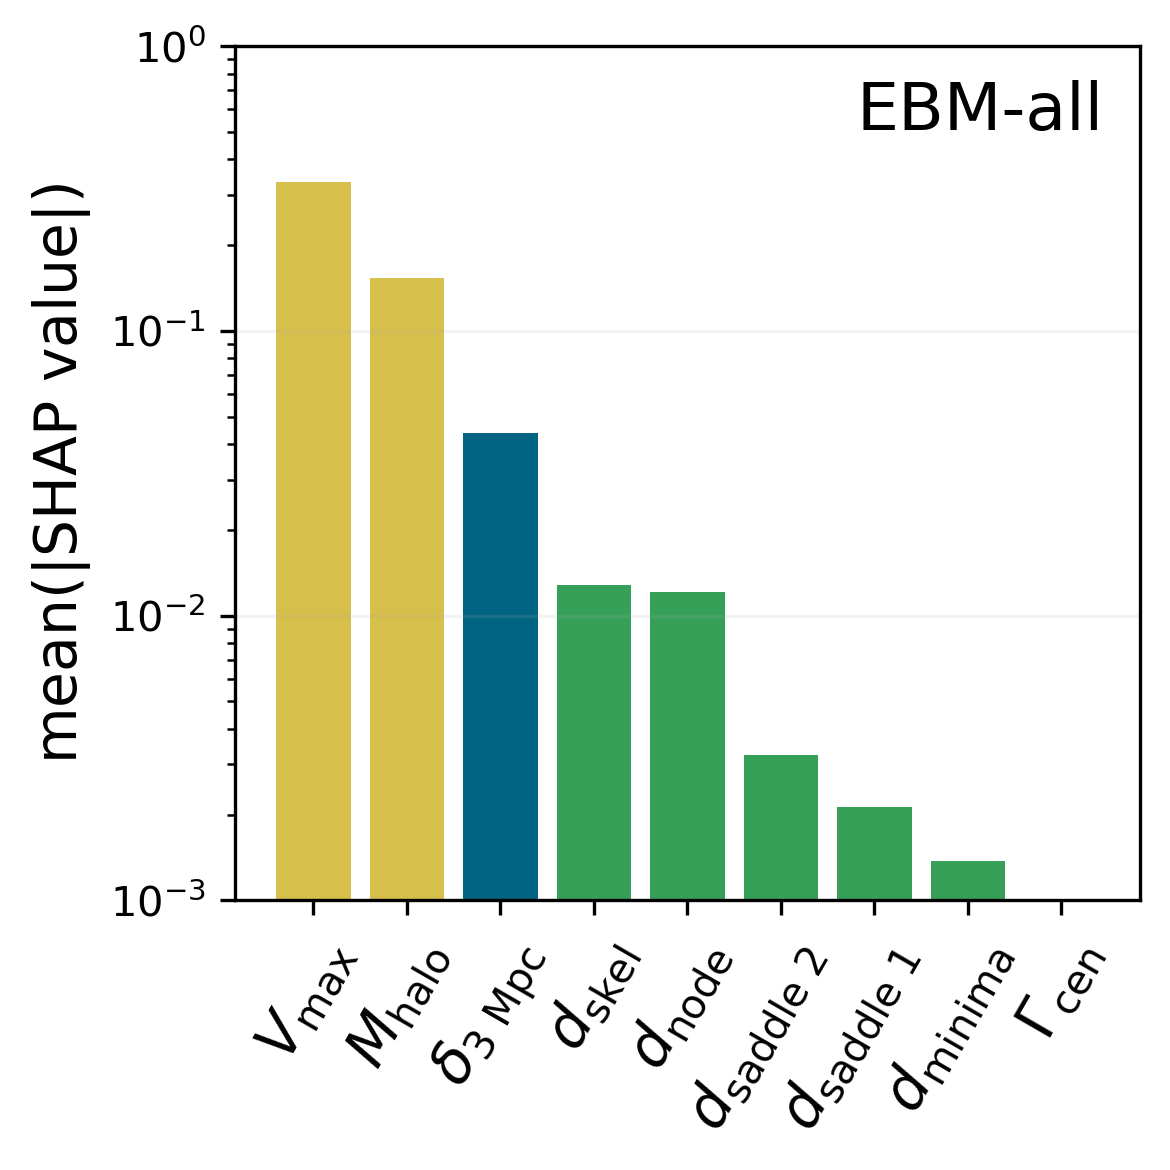

In [94]:
shap_ebm_all_results = pd.DataFrame(
        dict(
        names=[r"$M_{\rm halo}$", r"$V_{\rm max}$", r"$\Gamma_{\rm cen}$", r"$\delta_{3\ \rm Mpc}$", r"$d_{\rm minima}$", r"$d_{\rm node}$", r"$d_{\rm saddle\ 1}$", r"$d_{\rm saddle\ 2}$", r"$d_{\rm skel}$"],
        shap=shap_ebm_all.abs.mean(0).values,
        colors=[C0, C0, C0, C2, C1, C1, C1, C1, C1]
    )
).sort_values("shap", ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

ax.bar(range(len(shap_ebm_all_results)), shap_ebm_all_results.shap, color=shap_ebm_all_results.colors, log=True, tick_label=shap_ebm_all_results.names)

ax.set_ylim(1e-3, 1)
ax.set_xticklabels(shap_ebm_all_results.names, rotation=60, rotation_mode="anchor", ha="right", fontsize=14)
ax.set_ylabel(r"mean($\vert$SHAP value$\vert$)", fontsize=14)

ax.text(0.96, 0.96, "EBM-all", ha="right", va="top", fontsize=16, transform=ax.transAxes)

ax.yaxis.grid(alpha=0.15)
fig.tight_layout()
plt.savefig(f"{results_base_path}/ebm-all_importance.pdf", dpi=300)

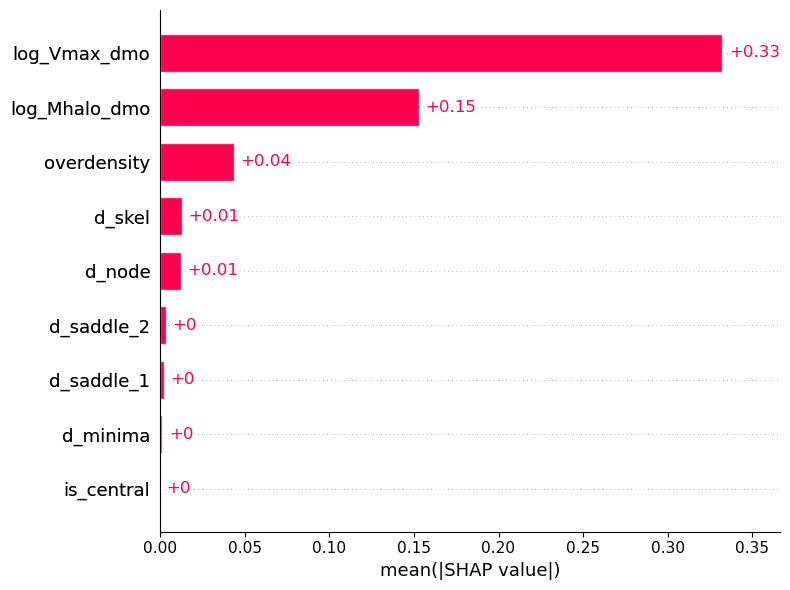

In [12]:
shap.plots.bar(shap_ebm_all.abs.mean(0), show=False)
plt.tight_layout()
# plt.savefig(f"{results_base_path}/ebm-all_importance.pdf", dpi=500)

## Overdensity feature importance as a function of D_link

Train one model that has all of the overdensities...

In [68]:
D_links = [0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 7.5, 10]

df_overdensity_all = pd.read_parquet(f"{results_base_path}/results-dmo_D_link0.3.parquet")
df_overdensity_all["is_central"] = df_overdensity_all["is_central"].astype(int)

df_overdensity_all.rename({"overdensity": "overdensity_0.3"}, axis=1, inplace=True)

for D_link in D_links[1:]:
    df = pd.read_parquet(f"{results_base_path}/results-dmo_D_link{D_link}.parquet")
    df_overdensity_all[f"overdensity_{D_link}"] = df["overdensity"]

df = df_overdensity_all.copy()


In [69]:
ebm_hyperparams = {
    "max_bins": 50000, 
    "validation_size": 0.3,
    "interactions": 32,
}

retrain_ebm = False

In [70]:
X = df[['log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central'] + [c for c in df.columns if c.startswith("overdensity")]]
y = df['log_Mstar']

p_EBM = []

for k in range(3):
    ebm_fname = f"{results_base_path}/linking_length_tests/models/ebm_overdensity_all-fold_{k}.pkl"

    train_mask = (df.k_fold != k)
    valid_mask = (df.k_fold == k)

    X_train, y_train = X[train_mask], y[train_mask]
    X_valid, y_valid = X[valid_mask], y[valid_mask]

    # EBM - all possible overdensities
    if Path(ebm_fname).exists() and not retrain_ebm:
        with open(ebm_fname, "rb") as f:
            ebm = pickle.load(f)
    else:
        ebm = ExplainableBoostingRegressor(**ebm_hyperparams)        
        ebm.fit(X_train, y_train)
        with open(ebm_fname, "wb") as f: 
            pickle.dump(ebm, f)
    
    y_pred = ebm.predict(X_valid)
    p_EBM += [y_pred]


In [7]:
scores = np.array([rmse(p_EBM[k], df[df.k_fold == k].log_Mstar) for k in range(3)])
print(f"{np.mean(scores):.4f} +/- {np.std(scores):.4f}")

0.1592 +/- 0.0017


In [8]:
# N_samples = 5000

# for k in range(3):
#     ebm_fname = f"{results_base_path}/linking_length_tests/models/ebm_overdensity_all-fold_{k}.pkl"

#     X_sample = X.sample(N_samples, replace=True, random_state=42)
    
#     with open(ebm_fname, "rb") as f:
#         ebm = pickle.load(f)

#     # save model
#     explainer_ebm = shap.Explainer(ebm.predict, X_sample)
#     shap_ebm = explainer_ebm(X_sample)

#     with open(f"{results_base_path}/linking_length_tests/models/shap_ebm_overdensity_all-fold_{k}.pkl", "wb") as f:
#         pickle.dump(shap_ebm, f)

In [71]:
abs_shap_overdensity_importances = []
shap_overdensity_importances = []

for D_link in D_links:
    abs_shap_means = []
    shap_means = []
    for k in range(3):


        with open(f"{results_base_path}/linking_length_tests/models/shap_ebm_overdensity_all-fold_{k}.pkl", "rb") as f:
            shap_ebm = pickle.load(f)

            abs_shap_means += [np.abs(shap_ebm[:, f"overdensity_{D_link}"].values).mean(0)]
            shap_means += [np.array(shap_ebm[:, f"overdensity_{D_link}"].values).mean(0)]
    
    abs_shap_overdensity_importances += [abs_shap_means]
    shap_overdensity_importances += [shap_means]

abs_shap_overdensity_importances = np.array(abs_shap_overdensity_importances)
shap_overdensity_importances = np.array(shap_overdensity_importances)


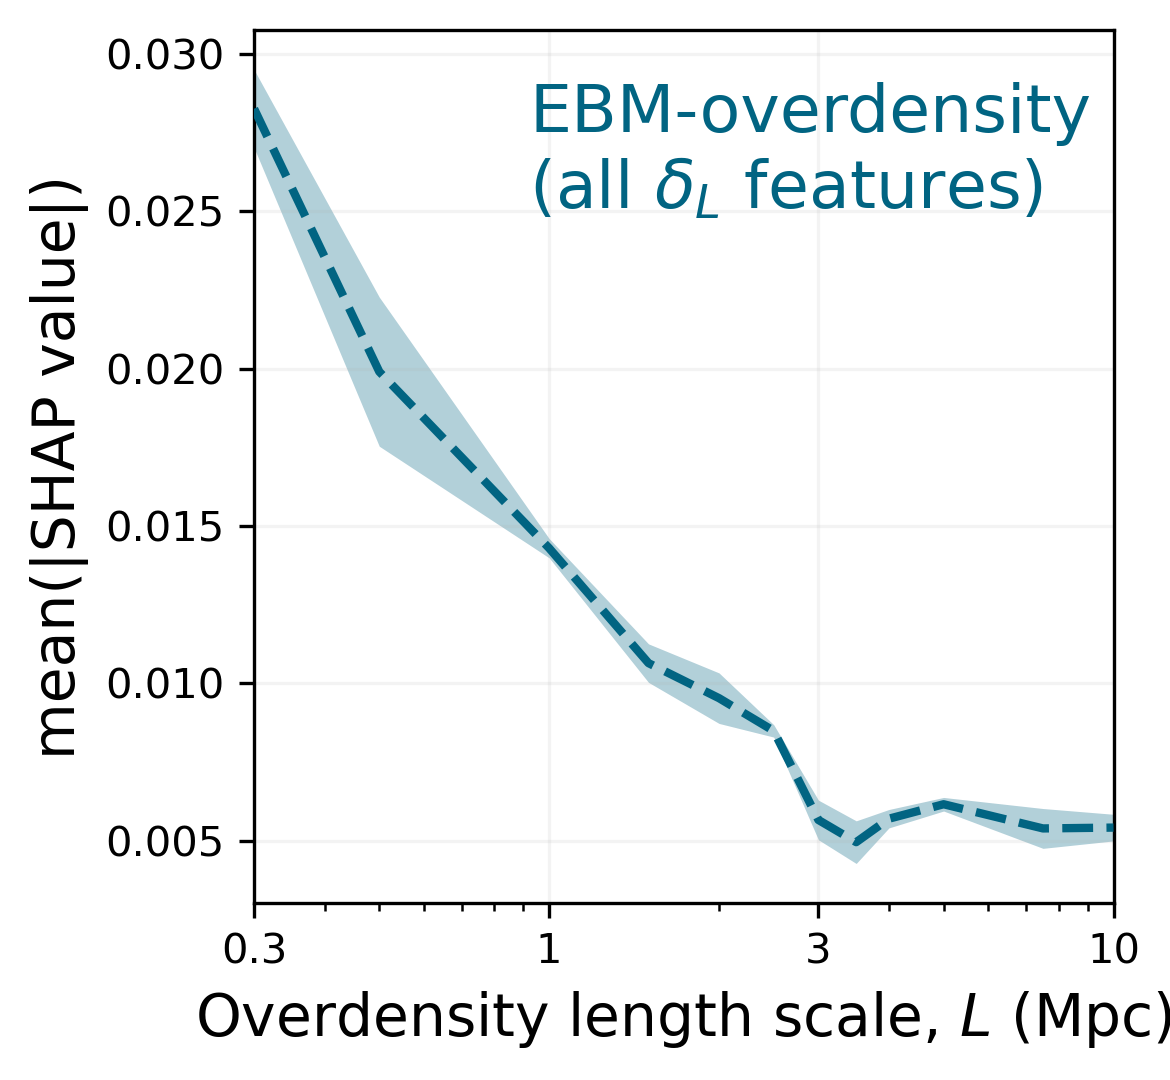

In [91]:
plt.figure(figsize=(4., 3.7), dpi=300)

plt.plot(D_links, np.mean(abs_shap_overdensity_importances, 1), c=C2, lw=2, ls="--", zorder=4)
plt.fill_between(D_links, np.mean(abs_shap_overdensity_importances, 1)-np.std(abs_shap_overdensity_importances, 1), np.mean(abs_shap_overdensity_importances, 1)+np.std(abs_shap_overdensity_importances, 1), color=C2, alpha=0.3, lw=0)
plt.grid(alpha=0.15)

plt.text(0.32, 0.94, "EBM-overdensity\n(all $\\delta_L$ features)", ha="left", va="top", transform=plt.gca().transAxes, fontsize=16, color=C2)

plt.xscale("log")
plt.xticks(ticks=[0.3, 1, 3, 10], labels=[0.3, 1, 3, 10])
# plt.grid(alpha=0.15)
plt.xlabel("Overdensity length scale, $L$ (Mpc)", fontsize=14)
plt.xlim(0.3, 10)
plt.ylabel("mean(|SHAP value|)", fontsize=14)

# plt.ylim(0.028, 0.057)
plt.tight_layout()

plt.savefig(f"{results_base_path}/EBM-overdensity-D_link-SHAP_abs_mean.pdf", dpi=300)

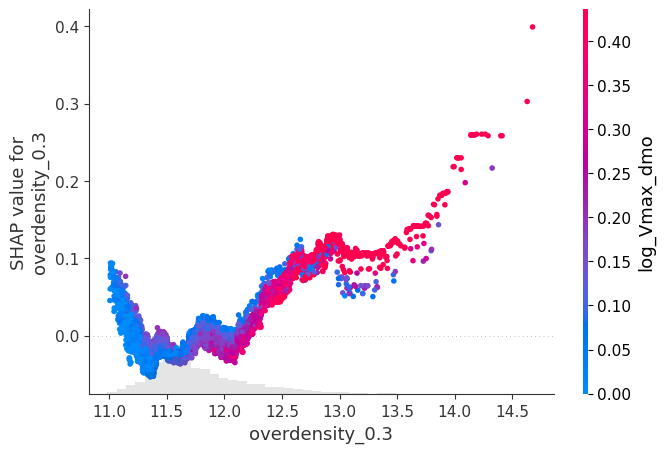

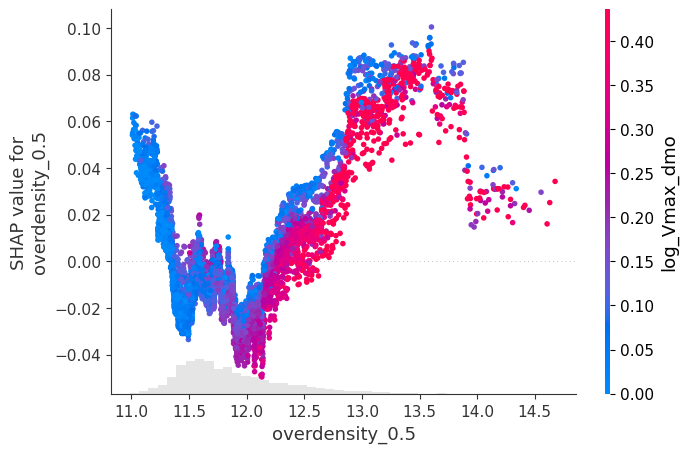

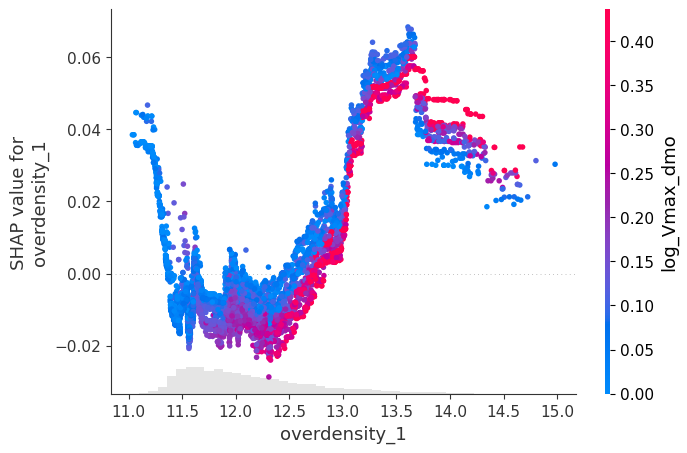

In [93]:
shap.plots.scatter(shap_ebm[:,3], color=shap_ebm[:,1]);
shap.plots.scatter(shap_ebm[:,4], color=shap_ebm[:,1]);
shap.plots.scatter(shap_ebm[:,5], color=shap_ebm[:,1]);


Interesting pattern above: at high 0.3 Mpc overdensity, we see that higher Vmax leads to high Mstar predictions. But at high 0.5 Mpc overdensity, we see that higher Vmax correlates with lower Mstar predictions. This may be in the highest-mass halos, where the subhalo Vmax quickly drops due to the subhalo being disrupted, while the high-Mstar galaxy remains intact?

This is also partially because 0.5 Mpc is a weird middle ground where the highest Mstar galaxies may still be satellites of the highest-mass Mhalo central halos. 

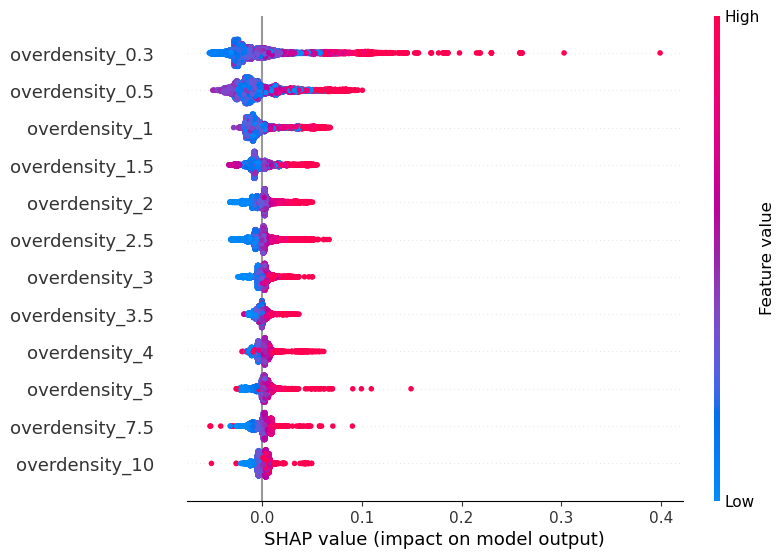

In [12]:
shap.plots.beeswarm(shap_ebm[:, 3:], max_display=12, order=range(len(D_links)))

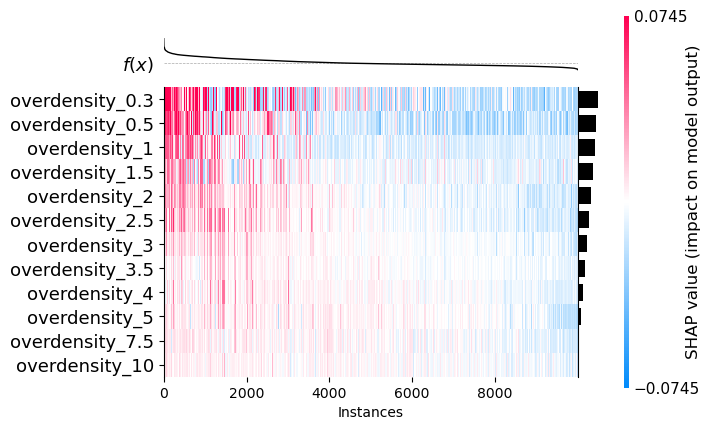

In [23]:
shap.plots.heatmap(shap_ebm[:, 3:], max_display=12, feature_values=np.arange(len(D_links))[::-1], instance_order=shap_ebm[:, 3:].mean(1), plot_width=6)

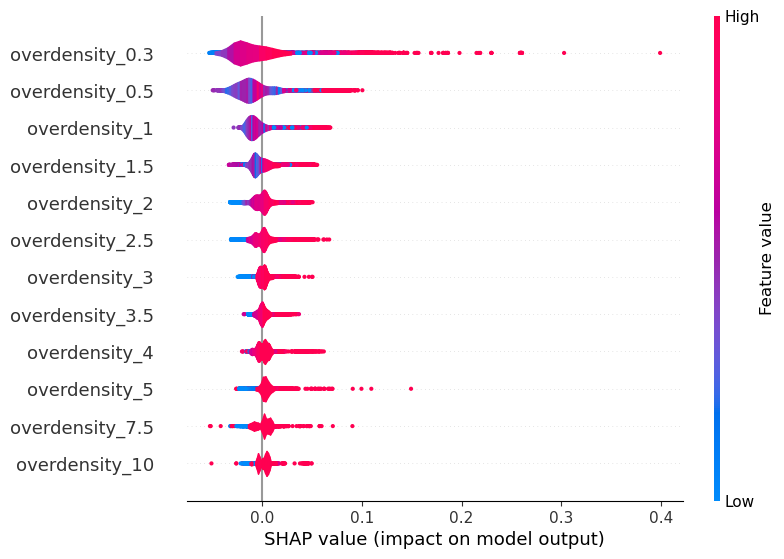

In [15]:
shap.plots.violin(shap_ebm[:, 3:], max_display=12, sort=False)

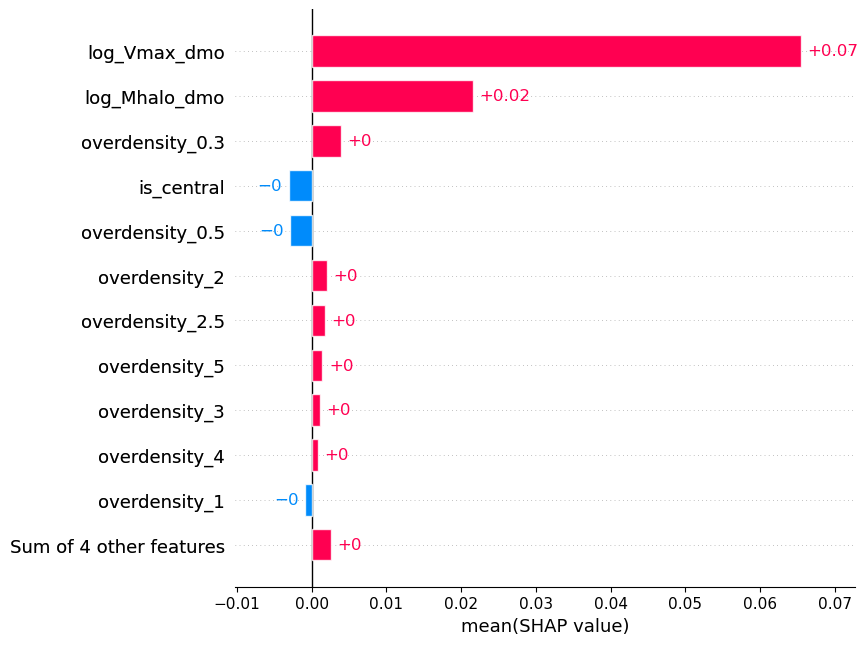

In [41]:
shap.plots.bar(shap_ebm.mean(0), max_display=12, )

## Overdensity in shells - feature importance vs D_link

In [3]:
D_links = [0.3, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 7.5, 10]

df_overdensity_all = pd.read_parquet(f"{results_base_path}/results-dmo_D_link0.3.parquet")
df_overdensity_all["is_central"] = df_overdensity_all["is_central"].astype(int)

df_overdensity_all.rename({"overdensity": "overdensity_0.3"}, axis=1, inplace=True)

for D_link in D_links[1:]:
    df = pd.read_parquet(f"{results_base_path}/results-dmo_D_link{D_link}.parquet")
    df_overdensity_all[f"overdensity_{D_link}"] = df["overdensity"]

df = df_overdensity_all.copy()


In [12]:
for i in reversed(range(len(D_links))):
    if i > 0:
        shell_mass = 10**df[f"overdensity_{D_links[i]}"] - 10**df[f"overdensity_{D_links[i-1]}"]
    else:
        shell_mass = 10**df[f"overdensity_{D_links[i]}"]
    
    df[f"shell_{D_links[i]}"] = shell_mass / 1e12

In [13]:
ebm_hyperparams = {
    "max_bins": 50000, 
    "validation_size": 0.3,
    "interactions": 32,
}

retrain_ebm = False

In [21]:
X = df[['log_Mhalo_dmo', 'log_Vmax_dmo', 'is_central'] + [c for c in df.columns if c.startswith("shell")]]
y = df['log_Mstar']

p_EBM = []

for k in range(3):
    ebm_fname = f"{results_base_path}/linking_length_tests/models/ebm_overdensity_shells-fold_{k}.pkl"

    train_mask = (df.k_fold != k)
    valid_mask = (df.k_fold == k)

    X_train, y_train = X[train_mask], y[train_mask]
    X_valid, y_valid = X[valid_mask], y[valid_mask]

    # EBM - all possible overdensities
    if Path(ebm_fname).exists() and not retrain_ebm:
        with open(ebm_fname, "rb") as f:
            ebm = pickle.load(f)
    else:
        ebm = ExplainableBoostingRegressor(**ebm_hyperparams)        
        ebm.fit(X_train, y_train)
        with open(ebm_fname, "wb") as f: 
            pickle.dump(ebm, f)
    
    y_pred = ebm.predict(X_valid)
    p_EBM += [y_pred]


In [23]:
scores = np.array([rmse(p_EBM[k], df[df.k_fold == k].log_Mstar) for k in range(3)])
print(f"{np.mean(scores):.4f} +/- {np.std(scores):.4f}")

0.1597 +/- 0.0016


In [22]:
# N_samples = 5000

# for k in range(3):
#     ebm_fname = f"{results_base_path}/linking_length_tests/models/ebm_overdensity_shells-fold_{k}.pkl"

#     X_sample = X.sample(N_samples, replace=True, random_state=42)
    
#     with open(ebm_fname, "rb") as f:
#         ebm = pickle.load(f)

#     # save model
#     explainer_ebm = shap.Explainer(ebm.predict, X_sample)
#     shap_ebm = explainer_ebm(X_sample)

#     with open(f"{results_base_path}/linking_length_tests/models/shap_ebm_overdensity_shells-fold_{k}.pkl", "wb") as f:
#         pickle.dump(shap_ebm, f)

PermutationExplainer explainer: 10001it [05:27, 29.69it/s]                           
PermutationExplainer explainer: 10001it [05:05, 31.68it/s]                          
PermutationExplainer explainer: 10001it [05:01, 32.10it/s]                          


In [42]:
abs_shap_overdensity_importances = []
shap_overdensity_importances = []

for D_link in D_links:
    abs_shap_means = []
    shap_means = []
    for k in range(3):


        with open(f"{results_base_path}/linking_length_tests/models/shap_ebm_overdensity_shells-fold_{k}.pkl", "rb") as f:
            shap_ebm = pickle.load(f)

            abs_shap_means += [np.abs(shap_ebm[:, f"shell_{D_link}"].values).mean(0)]
            shap_means += [np.array(shap_ebm[:, f"shell_{D_link}"].values).mean(0)]
    
    abs_shap_overdensity_importances += [abs_shap_means]
    shap_overdensity_importances += [shap_means]

abs_shap_overdensity_importances = np.array(abs_shap_overdensity_importances)
shap_overdensity_importances = np.array(shap_overdensity_importances)


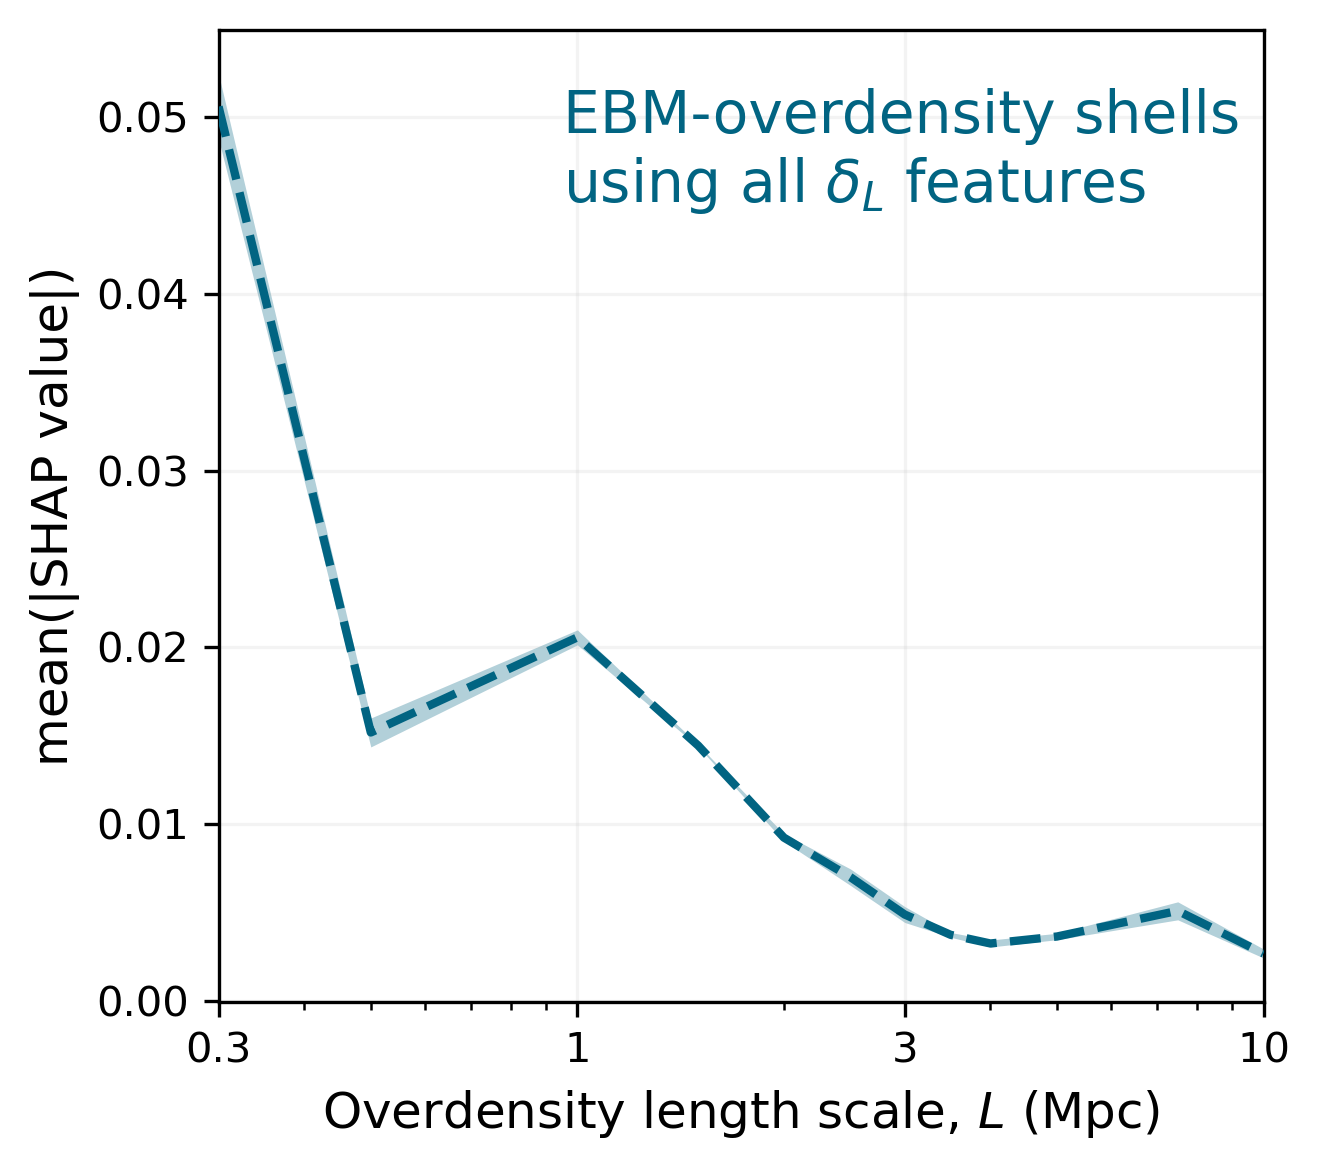

In [33]:
plt.figure(figsize=(4.5, 4.), dpi=300)

plt.plot(D_links, np.mean(abs_shap_overdensity_importances, 1), c=C2, lw=2, ls="--", zorder=4)
plt.fill_between(D_links, np.mean(abs_shap_overdensity_importances, 1)-np.std(abs_shap_overdensity_importances, 1), np.mean(abs_shap_overdensity_importances, 1)+np.std(abs_shap_overdensity_importances, 1), color=C2, alpha=0.3, lw=0)
plt.grid(alpha=0.15)

plt.text(0.33, 0.94, "EBM-overdensity shells\nusing all $\\delta_L$ features", ha="left", va="top", transform=plt.gca().transAxes, fontsize=14, color=C2)

plt.xscale("log")
plt.xticks(ticks=[0.3, 1, 3, 10], labels=[0.3, 1, 3, 10])
# plt.grid(alpha=0.15)
plt.xlabel("Overdensity length scale, $L$ (Mpc)", fontsize=12)
plt.xlim(0.3, 10)
plt.ylabel("mean(|SHAP value|)", fontsize=12)

# plt.ylim(0.028, 0.057)
plt.tight_layout()

plt.savefig(f"{results_base_path}/EBM-overdensity-shells-D_link-SHAP_abs_mean.pdf")

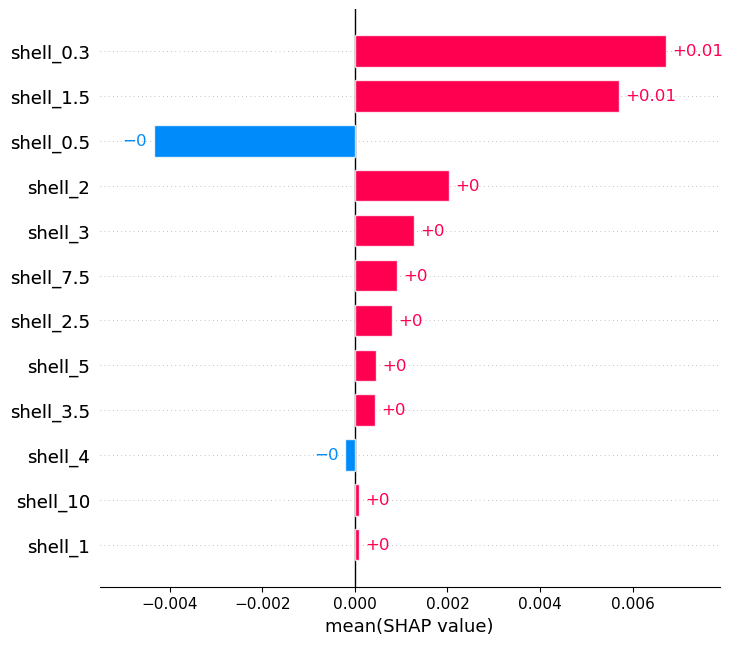

In [44]:
shap.plots.bar(shap_ebm[:, 3:].mean(0), max_display=12, )

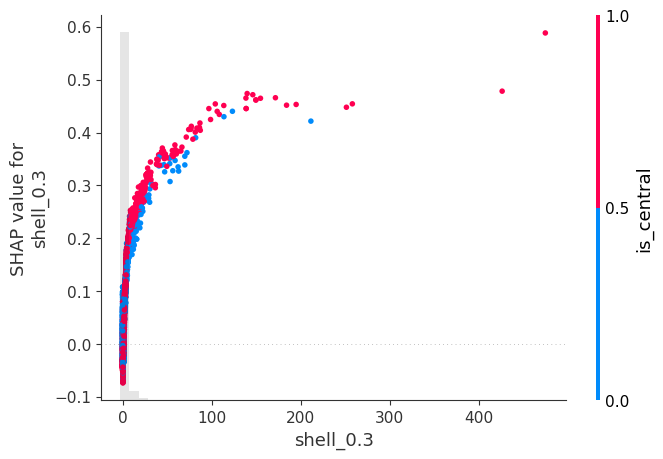

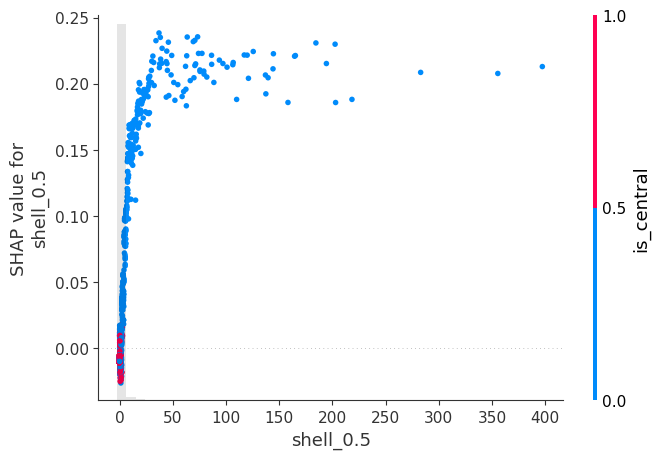

In [54]:
shap.plots.scatter(shap_ebm[:, -1], color=shap_ebm[:, 2]);
shap.plots.scatter(shap_ebm[:, -2], color=shap_ebm[:, 2]);

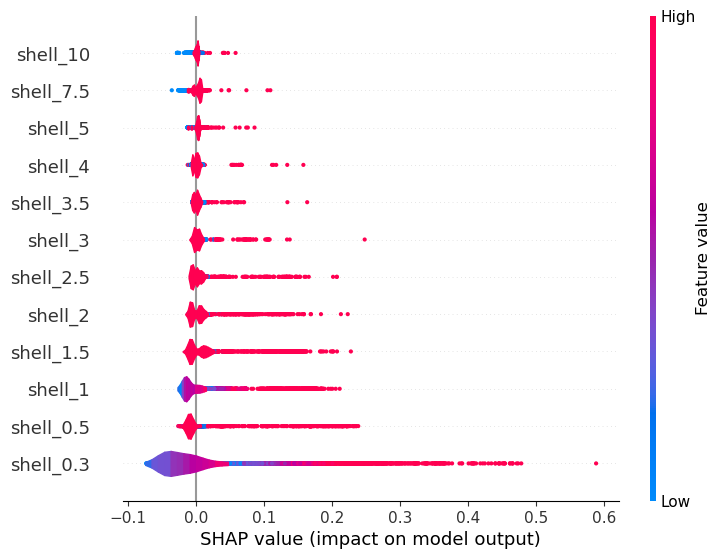

In [46]:
shap.plots.violin(shap_ebm[:, 3:], max_display=12, sort=False)

# Checks on SMF, clustering, etc.

## Figure 4: Stellar Mass Function

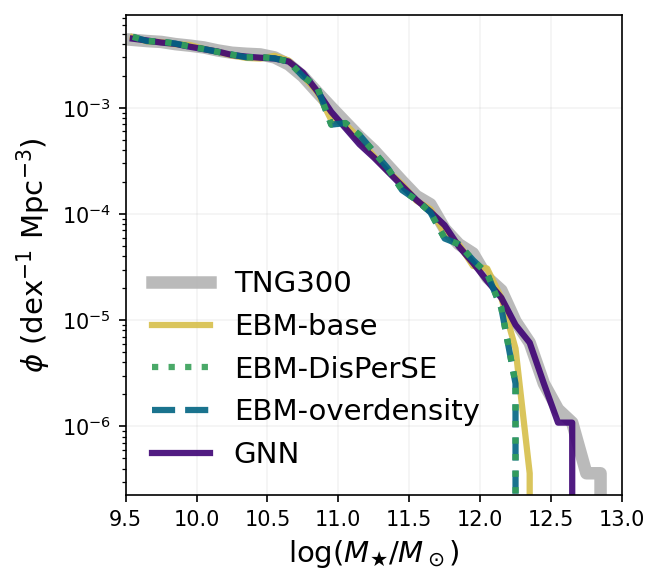

In [88]:
box_size = (205 / 0.6774)

volume = box_size**3

dbin = 0.1

N_true, mass_edges = np.histogram(df.log_Mstar, bins=np.arange(9.5, 14., dbin))
N_ebm_base, mass_edges = np.histogram(df.p_EBM_base, bins=np.arange(9.5, 14., dbin))
N_ebm_disperse, mass_edges = np.histogram(df.p_EBM_disperse, bins=np.arange(9.5, 14., dbin))
N_ebm_overdensity, mass_edges = np.histogram(df.p_EBM_overdensity, bins=np.arange(9.5, 14., dbin))
N_gnn, mass_edges = np.histogram(df.p_GNN_dmo, bins=np.arange(9.5, 14., dbin))

plt.figure(figsize=(4.5, 4), dpi=150)
l1 = plt.plot(
    (mass_edges[1:] + mass_edges[:-1]) / 2 ,  
    N_true / dbin / volume,
    ls="-",
    c="0.7",
    lw=6,
    alpha=0.9,
    label="TNG300"
)

l2 = plt.plot(
    (mass_edges[1:] + mass_edges[:-1]) / 2 ,  
    N_ebm_base / dbin / volume,
    ls="-",
    c=C0,
    lw=3,
    alpha=0.9,
    label="EBM-base"
)

l3 = plt.plot(
    (mass_edges[1:] + mass_edges[:-1]) / 2 ,  
    N_ebm_disperse / dbin / volume,
    ls=":",
    c=C1,
    lw=3,
    alpha=0.9,
    label="EBM-DisPerSE",
    zorder=9
)

l4 = plt.plot(
    (mass_edges[1:] + mass_edges[:-1]) / 2 ,  
    N_ebm_disperse / dbin / volume,
    ls="--",
    lw=3,
    c=C2,
    alpha=0.9,
    label="EBM-overdensity",
    zorder=7
)

l5 = plt.plot(
    (mass_edges[1:] + mass_edges[:-1]) / 2 ,  
    N_gnn / dbin / volume,
    ls="-",
    c=C3,
    lw=3,
    alpha=0.9,
    label="GNN"
)

plt.yscale('log')
plt.xlabel(r"$\log(M_\bigstar/M_\odot)$", fontsize=14)
plt.ylabel(r"$\phi$ (dex$^{-1}$ Mpc$^{-3}$)", fontsize=14)
plt.grid(alpha=0.15)
plt.xlim(9.5, 13)

plt.legend(fontsize=14, framealpha=0)
plt.tight_layout()
plt.savefig(f"{ROOT}/results/stellar-mass-function.pdf")

## Figure 5: 2pt corr

In [392]:
config = {
    "nbins": 15,
    "max_sep": 50,
    "min_sep": 0.5
}

def compute_2pt_LS(df, query, config=config, rng=rng, var_method="marked_bootstrap", m1=10, m2=11, N_patches=30):
    """query should indicate what predictor and the mass range. Some valid examples:
        query = Query("log_Mstar >= 9", "log_Mstar < 10")
        query = Query("p_GNN_dmo >= 10.5", "p_GNN_dmo < 11")
    """
    df_ = query.filter(df)

    cat = treecorr.Catalog(x=df_.x_dmo, y=df_.y_dmo, z=df_.z_dmo, npatch=N_patches)

    N_rand = Query(f"log_Mstar >= {m1}", f"log_Mstar < {m2}").count(df)
    random_pos = (rng.uniform(size=(3, N_rand)) - 0.5) * box_size 
    cat_rand = treecorr.Catalog(x=random_pos[0], y=random_pos[1], z=random_pos[2])

    # use landy-szalay estimator
    dd = treecorr.NNCorrelation(config)
    dr = treecorr.NNCorrelation(config)
    rd = treecorr.NNCorrelation(config)
    rr = treecorr.NNCorrelation(config)
    dd.process(cat)
    dr.process(cat, cat_rand)
    rd.process(cat_rand, cat)
    rr.process(cat_rand)
    xi, xi_var = dd.calculateXi(dr=dr, rr=rr, rd=rd)

    if var_method is not None:
        cov = dd.estimate_cov(var_method)

        # shot noise + covariance diagonals
        xi_err = np.sqrt(xi_var + np.diagonal(cov))
    else:
        xi_err = np.sqrt(xi_var)
    
    r = np.exp(dd.meanlogr)
    return r, xi, xi_err


def plot_2pt_and_scatter(r, xi, xi_err, color, lw, ls, label=None, replace_nans=True):

    if replace_nans:
        xi[(xi <= 1.0)] = np.nan

    l = plt.plot(r, xi, color=color, ls=ls, lw=lw, label=label)

    plt.fill_between(r, xi-xi_err, xi+xi_err, color=color, alpha=0.2, lw=0)
    return l

def plot_relative_2pt(xi, xi_err, xi_true, xi_true_err, color, lw, ls, label=None, ax=None, replace_nans=True):

    if replace_nans:
        xi[(xi <= 1.0)] = np.nan

    if ax == None: ax = plt.gca()
    l = ax.plot(r, xi / xi_true, 50, color=color, ls=ls, lw=lw, alpha=1, label=label);
    xi_ratio_err = xi / xi_true * np.sqrt((xi_err/xi)**2 + (xi_true_err/xi_true)**2)
    ax.fill_between(r, (xi/xi_true - xi_ratio_err), (xi/xi_true + xi_ratio_err), color=color, lw=0, alpha=0.1);
    return l


## Fig 5 a - Low mass (9-10.5)

In [423]:
m1 = 9
m2 = 10.5

N_rand = Query(f"log_Mstar > {m1}", f"log_Mstar <= {m2}").count(df)

# needed for corr funcs
box_size = (205 / 0.6774)
rng = np.random.RandomState(42)

D_link = 3

df = pd.read_parquet(f"{results_base_path}/results-dmo_D_link{D_link}.parquet")
df["is_central"] = df["is_central"].astype(int)

r, xi_true, xi_true_err = compute_2pt_LS(
    df, 
    Query(f"log_Mstar >= {m1}", f"log_Mstar < {m2}"),
    m1=m1, m2=m2
)
r, xi_ebm_base, xi_ebm_base_err = compute_2pt_LS(
    df, 
    Query(f"p_EBM_base >= {m1}", f"p_EBM_base < {m2}"),
    m1=m1, m2=m2
)
r, xi_ebm_disperse, xi_ebm_disperse_err = compute_2pt_LS(
    df, 
    Query(f"p_EBM_disperse >= {m1}", f"p_EBM_disperse < {m2}"),
    m1=m1, m2=m2
)
r, xi_ebm_overdensity, xi_ebm_overdensity_err = compute_2pt_LS(
    df, 
    Query(f"p_EBM_overdensity >= {m1}", f"p_EBM_overdensity < {m2}"),
    m1=m1, m2=m2
)
r, xi_gnn, xi_gnn_err = compute_2pt_LS(
    df, 
    Query(f"p_GNN_dmo >= {m1}", f"p_GNN_dmo < {m2}"),
    m1=m1, m2=m2
)


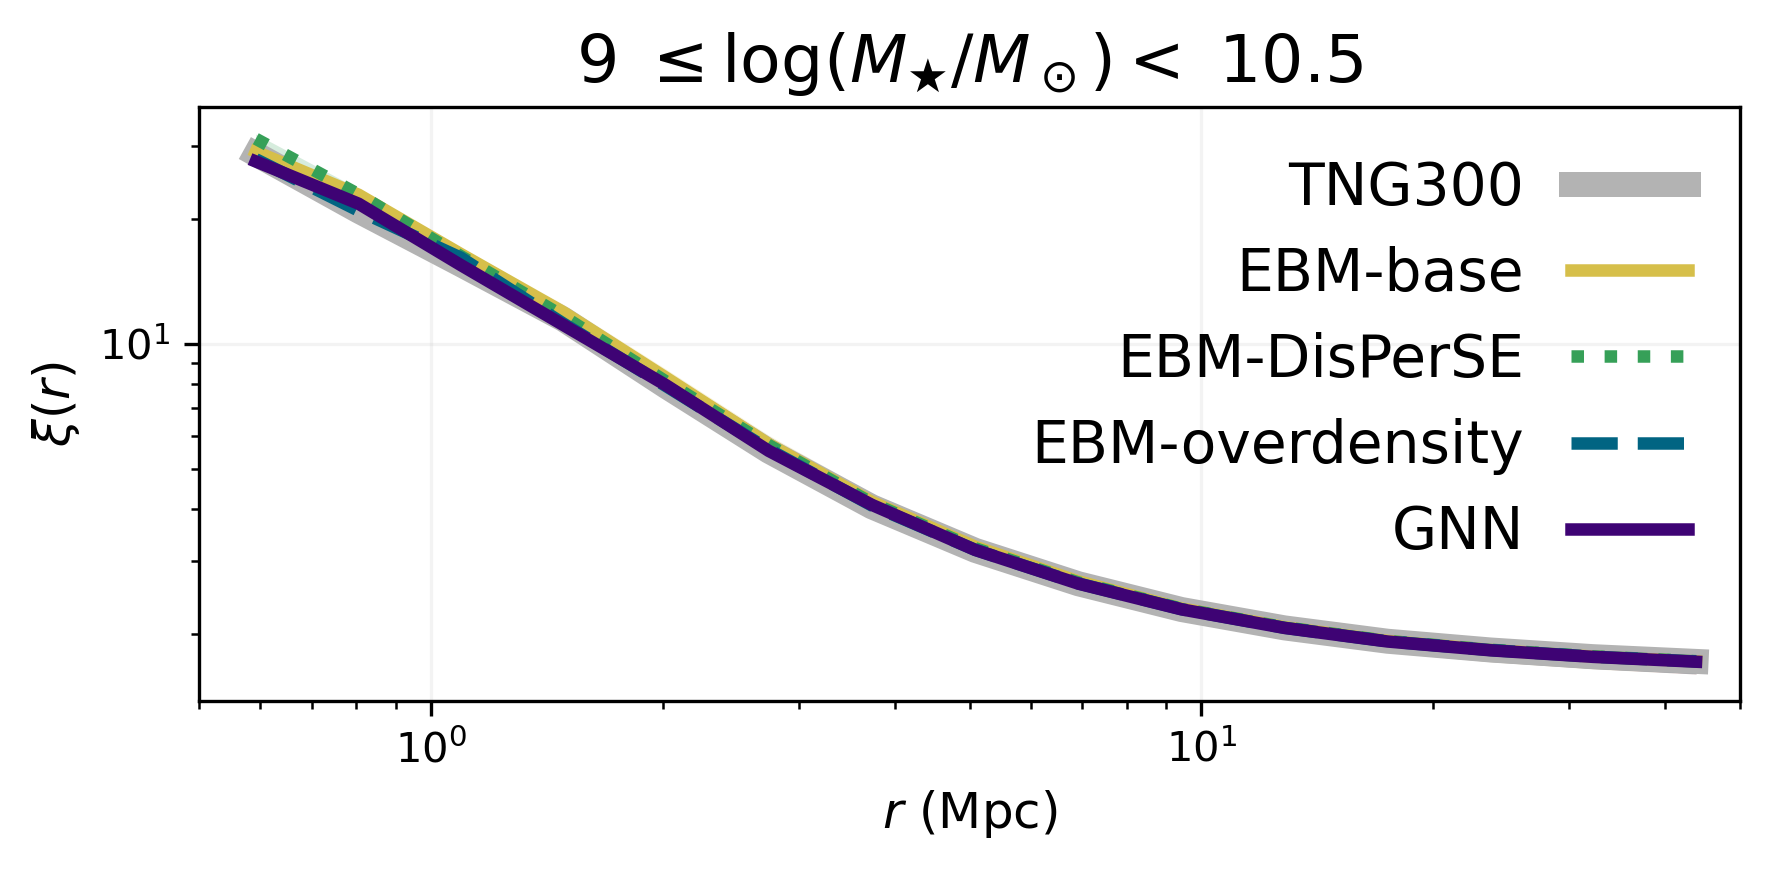

In [424]:
plt.figure(figsize=(6, 3), dpi=300)

l1 = plot_2pt_and_scatter(r, xi_true, xi_true_err, color="0.7", lw=6, ls="-", label="TNG300")
l2 = plot_2pt_and_scatter(r, xi_ebm_base, xi_ebm_base_err, color=C0, lw=3, ls="-", label="EBM-base")
l3 = plot_2pt_and_scatter(r, xi_ebm_disperse, xi_ebm_disperse_err, color=C1, lw=3, ls=":", label="EBM-DisPerSE")
l4 = plot_2pt_and_scatter(r, xi_ebm_overdensity, xi_ebm_overdensity_err, color=C2, lw=3, ls="--", label="EBM-overdensity")
l5 = plot_2pt_and_scatter(r, xi_gnn, xi_gnn_err, color=C3, lw=3, ls="-", label="GNN")

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$r$ (Mpc)', fontsize=12)
plt.ylabel(r'$\xi(r)$', fontsize=12)
# plt.ylim(2, 1e3)

plt.title(f"{m1} $\\leq \log(M_\\bigstar/M_\\odot) < $ {m2}", fontsize=16)

plt.legend(loc='upper right', fontsize=14, framealpha=0, markerfirst=False)
plt.xlim([config["min_sep"], config["max_sep"]])
plt.grid(alpha=0.15)

plt.tight_layout()

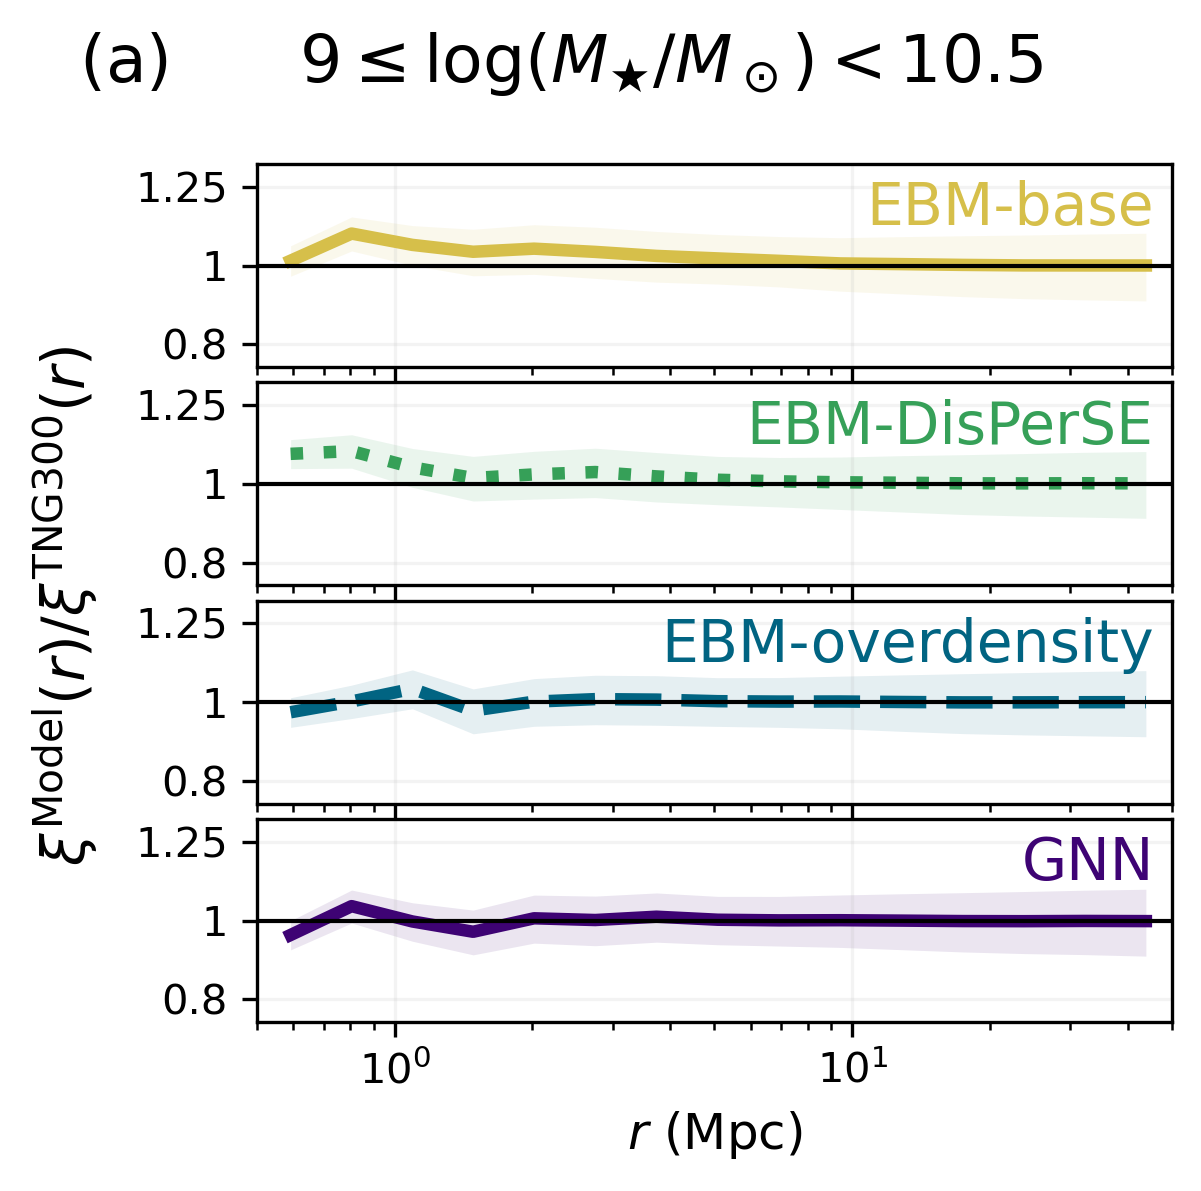

In [425]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, figsize=(4, 4), dpi=300, sharex=True)

plot_relative_2pt(xi_ebm_base, xi_ebm_base_err, xi_true, xi_true_err, color=C0, lw=3, ls="-", ax=ax1)
plot_relative_2pt(xi_ebm_disperse, xi_ebm_disperse_err, xi_true, xi_true_err, color=C1, lw=3, ls=":", ax=ax2)
plot_relative_2pt(xi_ebm_overdensity, xi_ebm_overdensity_err, xi_true, xi_true_err, color=C2, lw=3, ls="--", ax=ax3)
plot_relative_2pt(xi_gnn, xi_gnn_err, xi_true, xi_true_err, color=C3, lw=3, ls="-", ax=ax4)

ax4.set_xlabel(r'$r$ (Mpc)', fontsize=12)
ax4.set_xscale('log')
ax4.set_xlim([config["min_sep"], config["max_sep"]])

fig.suptitle(f"(a)      ${m1} \\leq \\log(M_\\bigstar/M_\\odot) < {m2}$      ", fontsize=16)
fig.subplots_adjust(hspace=0)

from matplotlib.ticker import MultipleLocator # absolutely ridiculous but okay

for ax, model_name, color in zip([ax1, ax2, ax3, ax4], ["EBM-base", "EBM-DisPerSE", "EBM-overdensity", "GNN"], [C0, C1, C2, C3]):
    ax.axhline(1, c="k", lw=1)
    ax.set_ylim(3/4, 4/3)
    ax.set_yscale("log")
    ax.yaxis.set_minor_locator(MultipleLocator(100))
    ax.text(0.98, 0.92, model_name, color=color, transform=ax.transAxes, fontsize=14, ha='right', va="top")
    ax.set_yticks(ticks=[0.8, 1, 1.25], labels=[0.8, 1, 1.25])
    ax.grid(alpha=0.15)

fig.tight_layout()

fig.subplots_adjust(left=0.2, hspace=0.075)
fig.text(0.04, 0.5, r'$\xi^{\rm Model}(r) / \xi^{\rm TNG300}(r)$', fontsize=14, rotation=90, ha="center", va='center')

plt.savefig(f"{results_base_path}/cross-correlation_low-mass.pdf", dpi=300)

## Fig 5 b - High-mass (10.5-12)

In [463]:
m1 = 10.5
m2 = 12

N_rand = Query(f"log_Mstar > {m1}", f"log_Mstar <= {m2}").count(df)

# needed for corr funcs
box_size = (205 / 0.6774)
rng = np.random.RandomState(42)

D_link = 3

df = pd.read_parquet(f"{results_base_path}/results-dmo_D_link{D_link}.parquet")
df["is_central"] = df["is_central"].astype(int)

r, xi_true, xi_true_err = compute_2pt_LS(
    df, 
    Query(f"log_Mstar >= {m1}", f"log_Mstar < {m2}"),
    m1=m1, m2=m2
)
r, xi_ebm_base, xi_ebm_base_err = compute_2pt_LS(
    df, 
    Query(f"p_EBM_base >= {m1}", f"p_EBM_base < {m2}"),75
    m1=m1, m2=m2
)
r, xi_ebm_disperse, xi_ebm_disperse_err = compute_2pt_LS(
    df, 
    Query(f"p_EBM_disperse >= {m1}", f"p_EBM_disperse < {m2}"),
    m1=m1, m2=m2
)
r, xi_ebm_overdensity, xi_ebm_overdensity_err = compute_2pt_LS(
    df, 
    Query(f"p_EBM_overdensity >= {m1}", f"p_EBM_overdensity < {m2}"),
    m1=m1, m2=m2
)
r, xi_gnn, xi_gnn_err = compute_2pt_LS(
    df, 
    Query(f"p_GNN_dmo >= {m1}", f"p_GNN_dmo < {m2}"),
    m1=m1, m2=m2
)


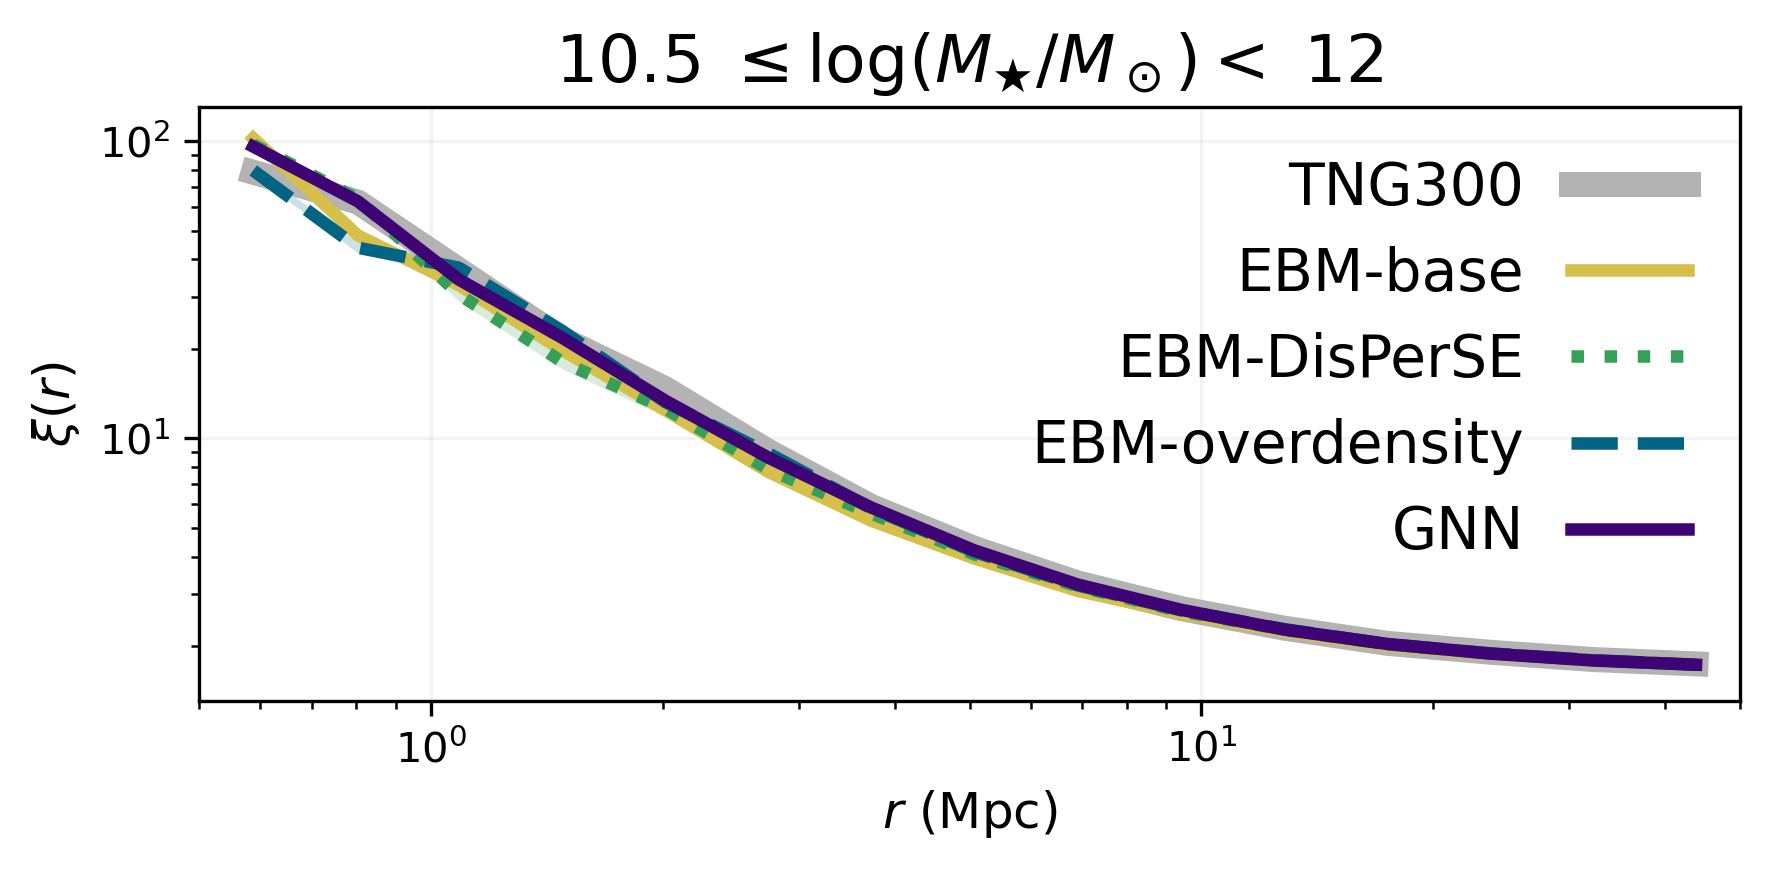

In [464]:
plt.figure(figsize=(6, 3), dpi=300)

l1 = plot_2pt_and_scatter(r, xi_true, xi_true_err, color="0.7", lw=6, ls="-", label="TNG300")
l2 = plot_2pt_and_scatter(r, xi_ebm_base, xi_ebm_base_err, color=C0, lw=3, ls="-", label="EBM-base")
l3 = plot_2pt_and_scatter(r, xi_ebm_disperse, xi_ebm_disperse_err, color=C1, lw=3, ls=":", label="EBM-DisPerSE")
l4 = plot_2pt_and_scatter(r, xi_ebm_overdensity, xi_ebm_overdensity_err, color=C2, lw=3, ls="--", label="EBM-overdensity")
l5 = plot_2pt_and_scatter(r, xi_gnn, xi_gnn_err, color=C3, lw=3, ls="-", label="GNN")

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$r$ (Mpc)', fontsize=12)
plt.ylabel(r'$\xi(r)$', fontsize=12)
# plt.ylim(2, 1e3)

plt.title(f"{m1} $\\leq \log(M_\\bigstar/M_\\odot) < $ {m2}", fontsize=16)

plt.legend(loc='upper right', fontsize=14, framealpha=0, markerfirst=False)
plt.xlim([config["min_sep"], config["max_sep"]])
plt.grid(alpha=0.15)

plt.tight_layout()

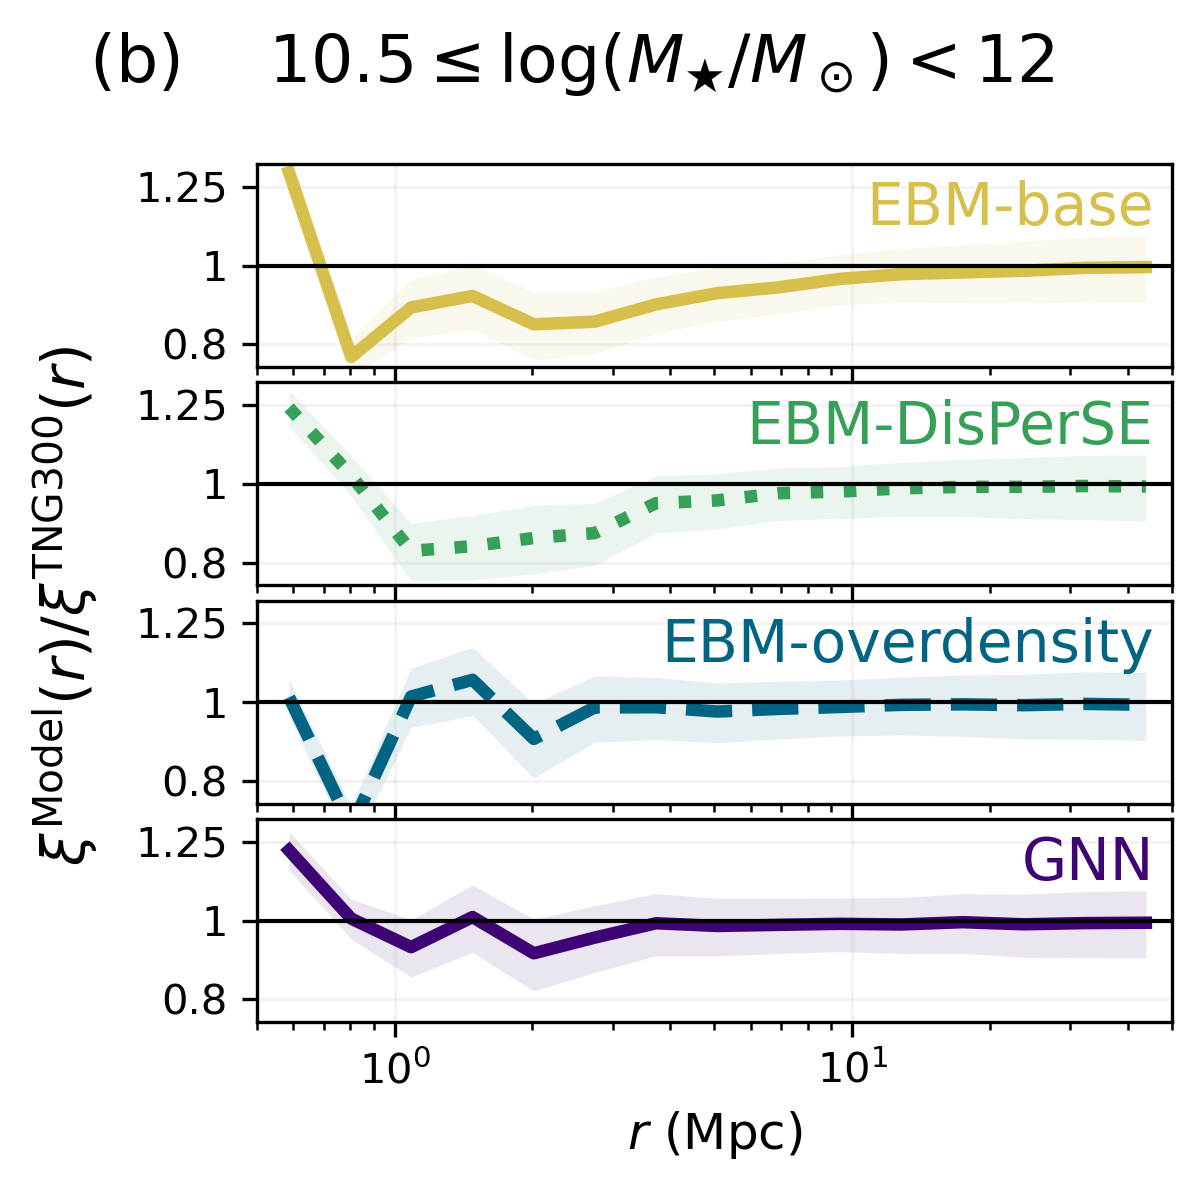

In [466]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, figsize=(4, 4), dpi=300, sharex=True)

plot_relative_2pt(xi_ebm_base, xi_ebm_base_err, xi_true, xi_true_err, color=C0, lw=3, ls="-", ax=ax1)
plot_relative_2pt(xi_ebm_disperse, xi_ebm_disperse_err, xi_true, xi_true_err, color=C1, lw=3, ls=":", ax=ax2)
plot_relative_2pt(xi_ebm_overdensity, xi_ebm_overdensity_err, xi_true, xi_true_err, color=C2, lw=3, ls="--", ax=ax3)
plot_relative_2pt(xi_gnn, xi_gnn_err, xi_true, xi_true_err, color=C3, lw=3, ls="-", ax=ax4)

ax4.set_xlabel(r'$r$ (Mpc)', fontsize=12)
ax4.set_xscale('log')
ax4.set_xlim([config["min_sep"], config["max_sep"]])

fig.suptitle(f"(b)    ${m1} \\leq \\log(M_\\bigstar/M_\\odot) < {m2}$     ", fontsize=16)
fig.subplots_adjust(hspace=0)

from matplotlib.ticker import MultipleLocator # absolutely ridiculous but okay

for ax, model_name, color in zip([ax1, ax2, ax3, ax4], ["EBM-base", "EBM-DisPerSE", "EBM-overdensity", "GNN"], [C0, C1, C2, C3]):
    ax.axhline(1, c="k", lw=1)
    ax.set_ylim(3/4, 4/3)
    ax.set_yscale("log")
    ax.yaxis.set_minor_locator(MultipleLocator(100))
    ax.text(0.98, 0.92, model_name, color=color, transform=ax.transAxes, fontsize=14, ha='right', va="top")
    ax.set_yticks(ticks=[0.8, 1, 1.25], labels=[0.8, 1, 1.25])
    ax.grid(alpha=0.15)

fig.tight_layout()

fig.subplots_adjust(left=0.2, hspace=0.075)
fig.text(0.04, 0.5, r'$\xi^{\rm Model}(r) / \xi^{\rm TNG300}(r)$', fontsize=14, rotation=90, ha="center", va='center')

plt.savefig(f"{results_base_path}/cross-correlation_high-mass.pdf", dpi=300)

# S/H mass vs overdensity

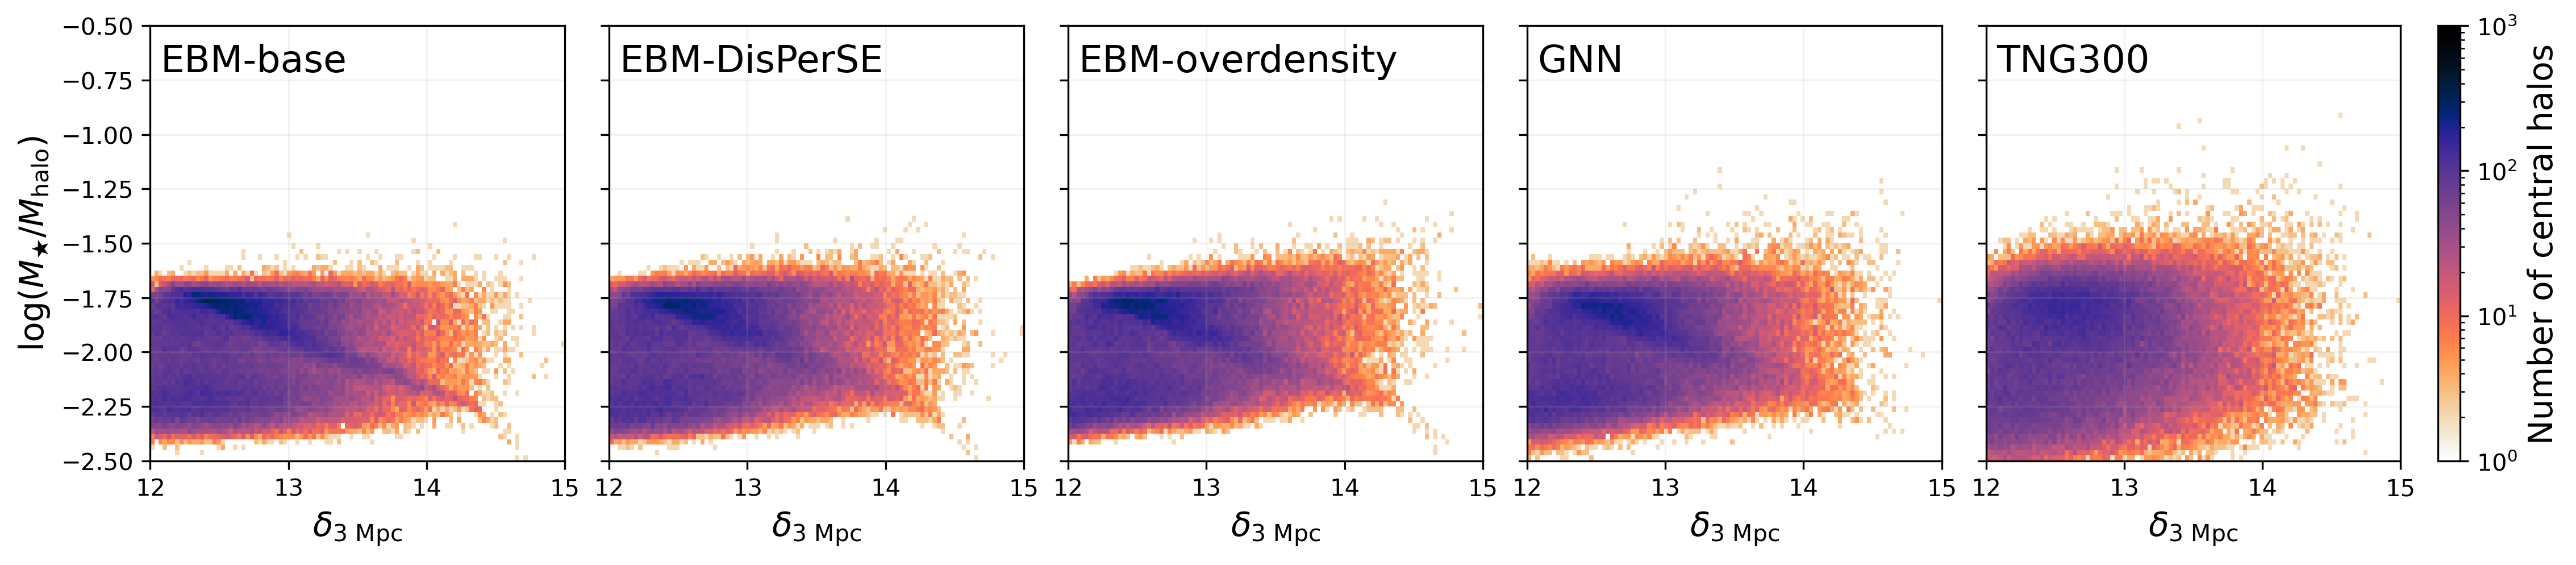

In [582]:
fig = plt.figure(figsize=(15, 3.2), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(1, 5, wspace=0.02, left=0.025, right=0.925, bottom=0.06, top=0.975, )
axes = gs.subplots(sharey="row")

ax1, ax2, ax3, ax4, ax5 = axes

hist2d_kwargs = dict(range=[(12, 15), (-2.5, -0.5)], bins=[100, 80], cmap=cmr.torch_r, norm=matplotlib.colors.LogNorm(vmin=1, vmax=1e3), rasterized=True)
df = pd.read_parquet(f"{results_base_path}/results-dmo_D_link{D_link}.parquet")
df = Query("is_central == True").filter(df)

ax1.hist2d(df.overdensity, df.p_EBM_base - df.log_Mhalo_dmo, **hist2d_kwargs)
ax1.text(0.025, 0.96, f"EBM-base", va="top", transform=ax1.transAxes, fontsize=16)

ax2.hist2d(df.overdensity, df.p_EBM_disperse - df.log_Mhalo_dmo, **hist2d_kwargs)
ax2.text(0.025, 0.96, f"EBM-DisPerSE", va="top", transform=ax2.transAxes, fontsize=16)

ax3.hist2d(df.overdensity, df.p_EBM_overdensity - df.log_Mhalo_dmo, **hist2d_kwargs)
ax3.text(0.025, 0.96, f"EBM-overdensity", va="top", transform=ax3.transAxes, fontsize=16)

ax4.hist2d(df.overdensity, df.p_GNN_dmo - df.log_Mhalo_dmo, **hist2d_kwargs)
ax4.text(0.025, 0.96, f"GNN", va="top", transform=ax4.transAxes, fontsize=16)

_, _, _, h = ax5.hist2d(df.overdensity, df.log_Mstar - df.log_Mhalo_dmo, **hist2d_kwargs)
ax5.text(0.025, 0.96, f"TNG300", va="top", transform=ax5.transAxes, fontsize=16)

cb = fig.colorbar(h, ax=axes, pad=0.01, shrink=1.)
cb.set_label("Number of central halos", fontsize=14)


for ax in axes:
    ax.grid(alpha=0.15)

    if ax == axes[0]:
        ax.set_ylabel("log($M_{\\bigstar}/M_{\\rm halo}}$)", fontsize=14)
    ax.set_xlabel("$\\delta_{3\ \\rm Mpc}$", fontsize=14)

plt.savefig(f"{results_base_path}/SHMR-overdensity-centrals.pdf")

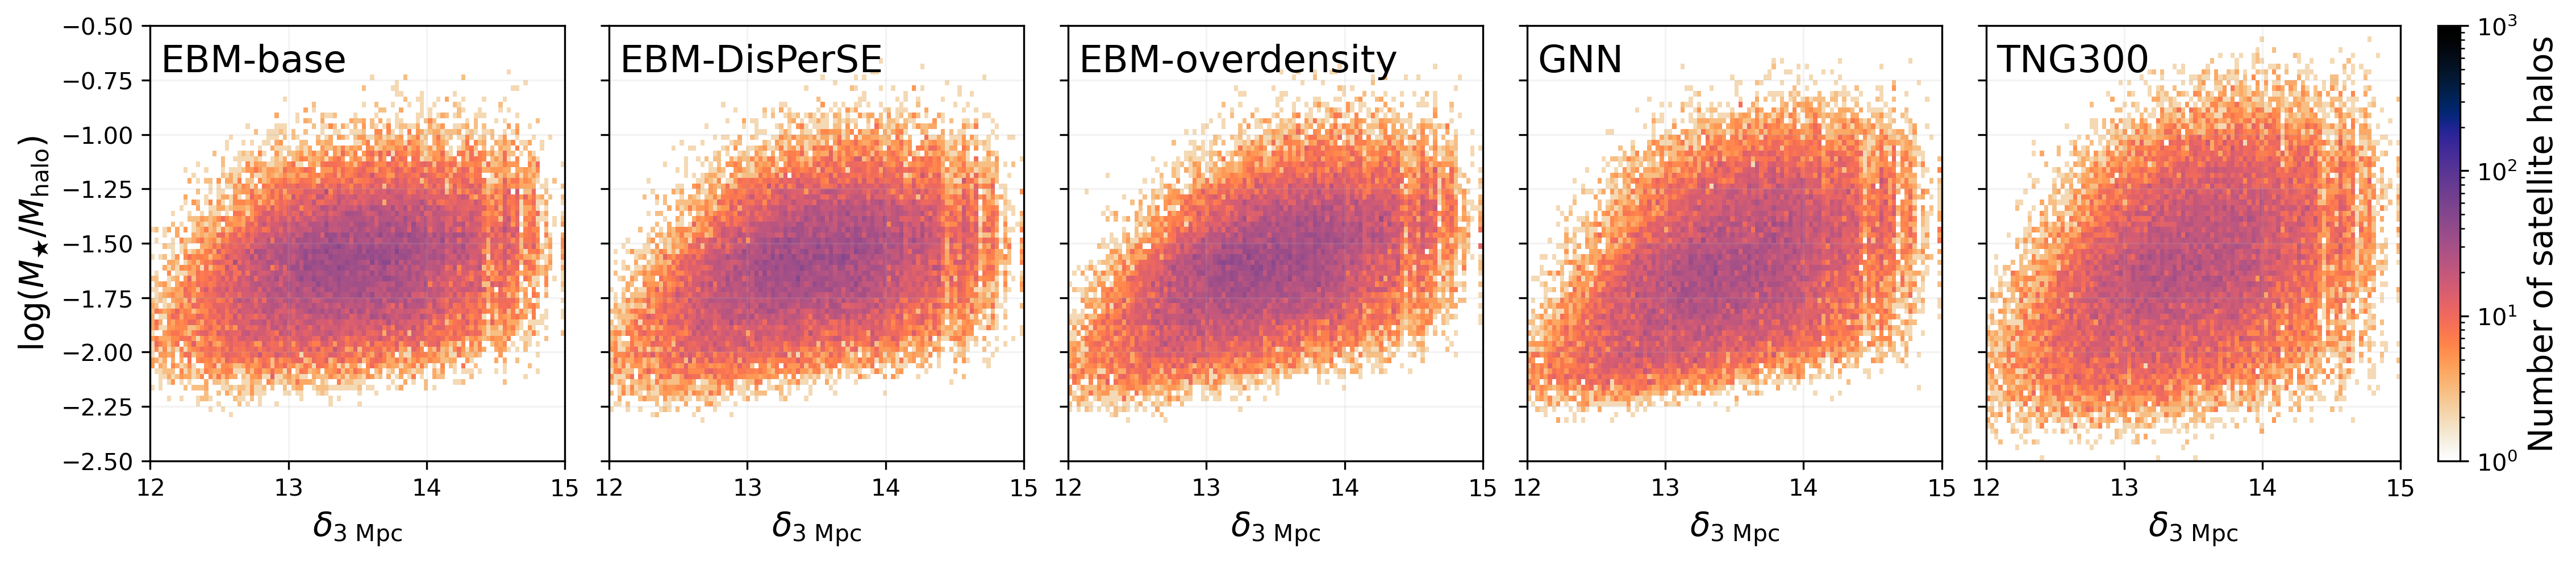

In [572]:
fig = plt.figure(figsize=(15, 3.2), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(1, 5, wspace=0.02, left=0.025, right=0.925, bottom=0.06, top=0.975, )
axes = gs.subplots(sharey="row")

ax1, ax2, ax3, ax4, ax5 = axes

hist2d_kwargs = dict(range=[(12, 15), (-2.5, -0.5)], bins=[100, 80], cmap=cmr.torch_r, norm=matplotlib.colors.LogNorm(vmin=1, vmax=1e3), rasterized=True)
df = pd.read_parquet(f"{results_base_path}/results-dmo_D_link{D_link}.parquet")
df = Query("is_central == False").filter(df)

ax1.hist2d(df.overdensity, df.p_EBM_base - df.log_Mhalo_dmo, **hist2d_kwargs)
ax1.text(0.025, 0.96, f"EBM-base", va="top", transform=ax1.transAxes, fontsize=16)

ax2.hist2d(df.overdensity, df.p_EBM_disperse - df.log_Mhalo_dmo, **hist2d_kwargs)
ax2.text(0.025, 0.96, f"EBM-DisPerSE", va="top", transform=ax2.transAxes, fontsize=16)

ax3.hist2d(df.overdensity, df.p_EBM_overdensity - df.log_Mhalo_dmo, **hist2d_kwargs)
ax3.text(0.025, 0.96, f"EBM-overdensity", va="top", transform=ax3.transAxes, fontsize=16)

ax4.hist2d(df.overdensity, df.p_GNN_dmo - df.log_Mhalo_dmo, **hist2d_kwargs)
ax4.text(0.025, 0.96, f"GNN", va="top", transform=ax4.transAxes, fontsize=16)

_, _, _, h = ax5.hist2d(df.overdensity, df.log_Mstar - df.log_Mhalo_dmo, **hist2d_kwargs)
ax5.text(0.025, 0.96, f"TNG300", va="top", transform=ax5.transAxes, fontsize=16)

cb = fig.colorbar(h, ax=axes, pad=0.01, shrink=1.)
cb.set_label("Number of satellite halos", fontsize=14)


for ax in axes:
    ax.grid(alpha=0.15)

    if ax == axes[0]:
        ax.set_ylabel("log($M_{\\bigstar}/M_{\\rm halo}}$)", fontsize=14)
    ax.set_xlabel("$\\delta_{3\ \\rm Mpc}$", fontsize=14)

plt.savefig(f"{results_base_path}/SHMR-overdensity-satellites.pdf")

# SHAM results...

In [96]:
D_link = 3
df = pd.read_parquet(f"{results_base_path}/results-dmo_D_link{D_link}.parquet")


# # subhalo abundance matching results
sham_dmo_central = np.vstack([list(reversed(sorted((df.log_Mhalo_dmo[df.is_central])))), list(reversed(sorted(df.log_Mstar[df.is_central])))])
sham_dmo_satellite = np.vstack([list(reversed(sorted((df.log_Mhalo_dmo[~df.is_central])))), list(reversed(sorted(df.log_Mstar[~df.is_central])))])
sham_dmo_central_interp = lambda Mh: np.interp(Mh, *sham_dmo_central.T[::-1].T)
sham_dmo_satellite_interp = lambda Mh: np.interp(Mh, *sham_dmo_satellite.T[::-1].T)
sham_dmo_predictions = lambda Mh, cen: np.where(cen, sham_dmo_central_interp(Mh), sham_dmo_satellite_interp(Mh))
Mstar_sham_dmo = np.array([sham_dmo_predictions(Mh, cen) for Mh, cen in zip(df.log_Mhalo_dmo, df.is_central)], dtype=float)

df["p_sham_mhalo"] = Mstar_sham_dmo

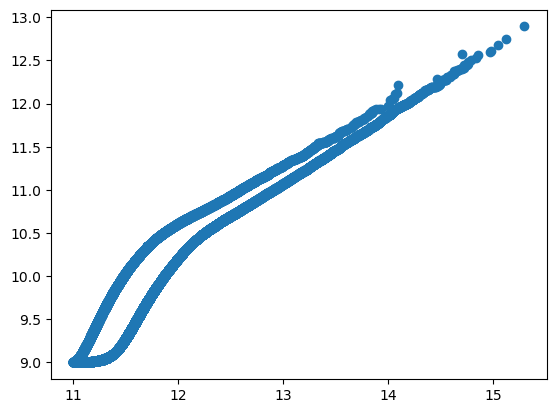

In [36]:
plt.scatter(df.log_Mhalo_dmo, df.p_sham_mhalo)

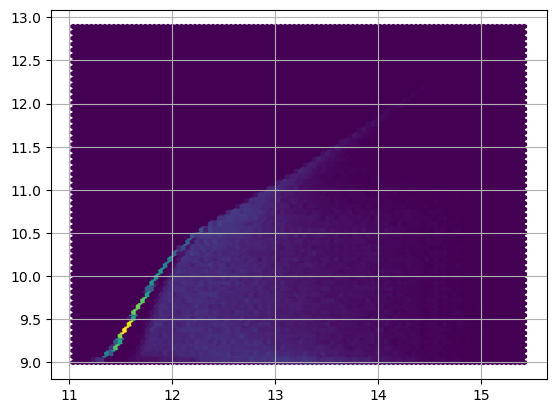

In [37]:
plt.hexbin(df.overdensity, df.p_sham_mhalo)
plt.grid()

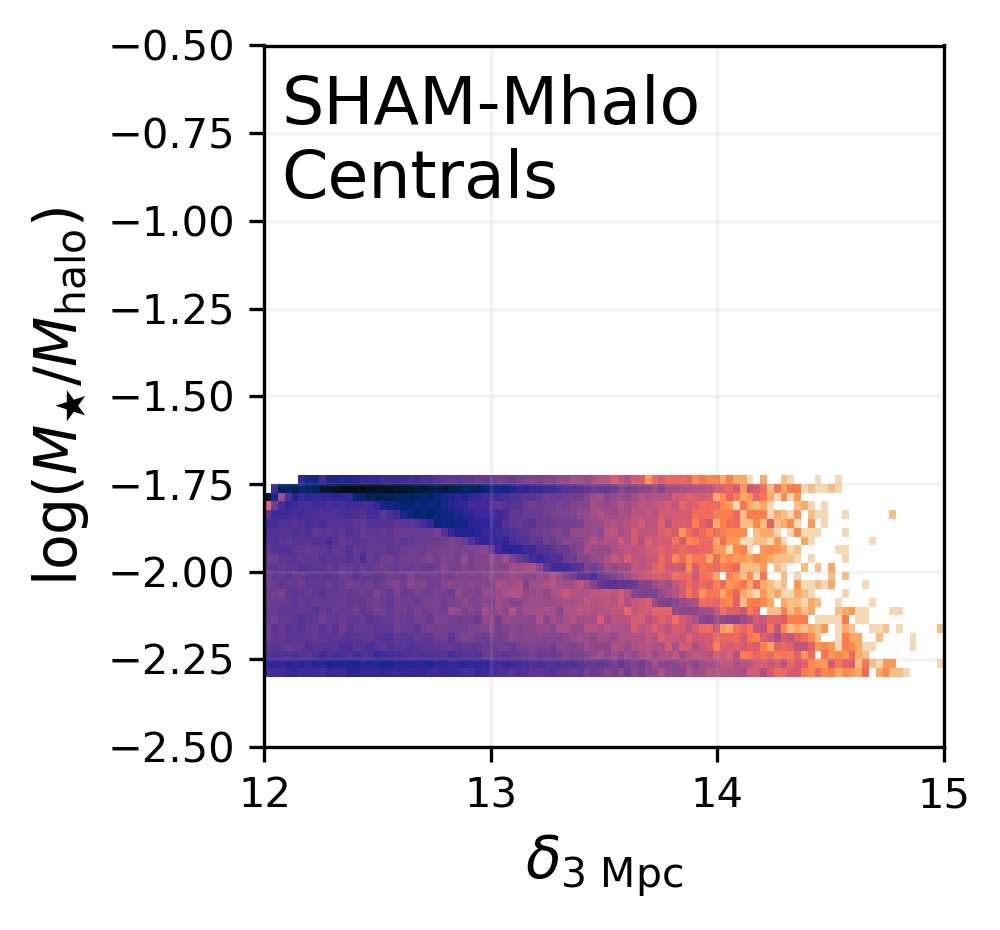

In [49]:
cen = Query("is_central")
plt.figure(figsize=(3.5, 3.2), dpi=300)
hist2d_kwargs = dict(range=[(12, 15), (-2.5, -0.5)], bins=[100, 80], cmap=cmr.torch_r, norm=matplotlib.colors.LogNorm(vmin=1, vmax=1e3), rasterized=True)

plt.hist2d(cen.filter(df).overdensity, cen.filter(df).p_sham_mhalo - cen.filter(df).log_Mhalo_dmo, **hist2d_kwargs);

plt.text(0.025, 0.96, f"SHAM-Mhalo\nCentrals", va="top", transform=plt.gca().transAxes, fontsize=16)


plt.grid(alpha=0.15)
plt.xlabel("$\\delta_{3\ \\rm Mpc}$", fontsize=14)
plt.ylabel("log($M_{\\bigstar}/M_{\\rm halo}}$)", fontsize=14)
plt.tight_layout()
plt.savefig(f"{results_base_path}/SHMR-overdensity-centrals-SHAM.pdf")

Text(0, 0.5, 'log($M_{\\bigstar}/M_{\\rm halo}}$)')

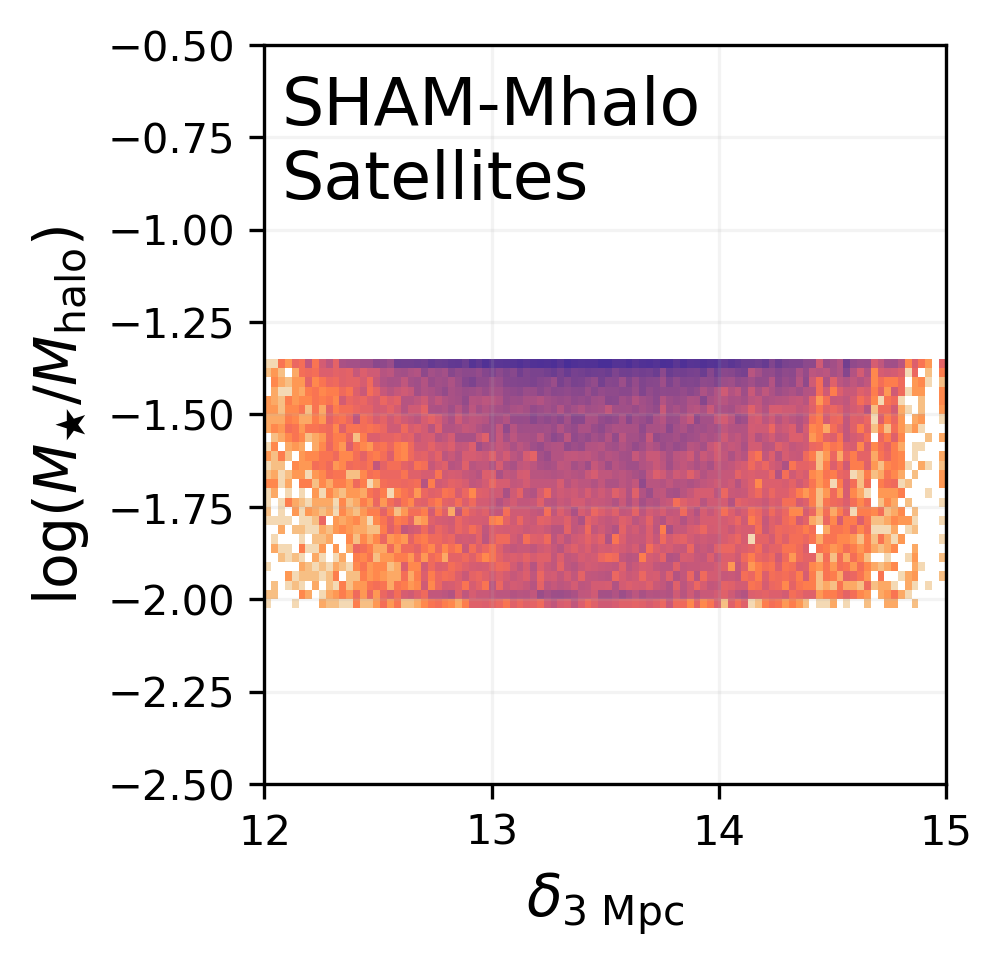

In [44]:
cen = Query("is_central")
plt.figure(figsize=(2.93, 3.2), dpi=300)
hist2d_kwargs = dict(range=[(12, 15), (-2.5, -0.5)], bins=[100, 80], cmap=cmr.torch_r, norm=matplotlib.colors.LogNorm(vmin=1, vmax=1e3), rasterized=True)

plt.hist2d((~cen).filter(df).overdensity, (~cen).filter(df).p_sham_mhalo - (~cen).filter(df).log_Mhalo_dmo, **hist2d_kwargs);

plt.text(0.025, 0.96, f"SHAM-Mhalo\nSatellites", va="top", transform=plt.gca().transAxes, fontsize=16)


plt.grid(alpha=0.15)
plt.xlabel("$\\delta_{3\ \\rm Mpc}$", fontsize=14)
plt.ylabel("log($M_{\\bigstar}/M_{\\rm halo}}$)", fontsize=14)

In [97]:
df_with_sham = df.copy()

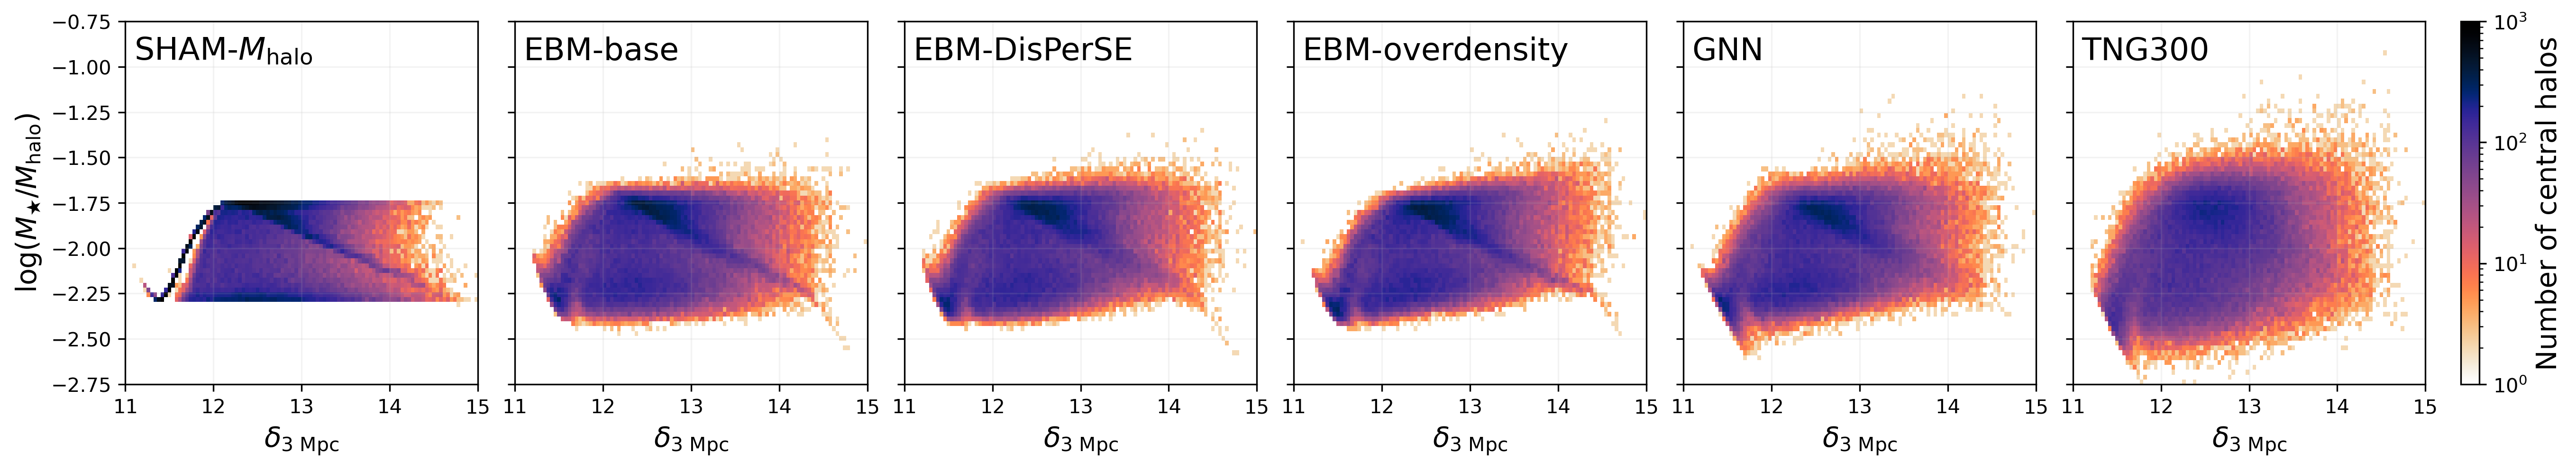

In [109]:
fig = plt.figure(figsize=(18, 3.2), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(1, 6, wspace=0.02, left=0.025, right=0.925, bottom=0.06, top=0.975, )
axes = gs.subplots(sharey="row")

ax0, ax1, ax2, ax3, ax4, ax5 = axes

hist2d_kwargs = dict(range=[(11, 15), (-2.75, -0.75)], bins=[100, 75], cmap=cmr.torch_r, norm=matplotlib.colors.LogNorm(vmin=1, vmax=1e3), rasterized=True)
df = Query("is_central == True").filter(df_with_sham)

ax0.hist2d(df.overdensity, df.p_sham_mhalo - df.log_Mhalo_dmo, **hist2d_kwargs)
ax0.text(0.025, 0.96, f"SHAM-$M_{{\\rm halo}}$", va="top", transform=ax0.transAxes, fontsize=16)

ax1.hist2d(df.overdensity, df.p_EBM_base - df.log_Mhalo_dmo, **hist2d_kwargs)
ax1.text(0.025, 0.96, f"EBM-base", va="top", transform=ax1.transAxes, fontsize=16)

ax2.hist2d(df.overdensity, df.p_EBM_disperse - df.log_Mhalo_dmo, **hist2d_kwargs)
ax2.text(0.025, 0.96, f"EBM-DisPerSE", va="top", transform=ax2.transAxes, fontsize=16)

ax3.hist2d(df.overdensity, df.p_EBM_overdensity - df.log_Mhalo_dmo, **hist2d_kwargs)
ax3.text(0.025, 0.96, f"EBM-overdensity", va="top", transform=ax3.transAxes, fontsize=16)

ax4.hist2d(df.overdensity, df.p_GNN_dmo - df.log_Mhalo_dmo, **hist2d_kwargs)
ax4.text(0.025, 0.96, f"GNN", va="top", transform=ax4.transAxes, fontsize=16)

_, _, _, h = ax5.hist2d(df.overdensity, df.log_Mstar - df.log_Mhalo_dmo, **hist2d_kwargs)
ax5.text(0.025, 0.96, f"TNG300", va="top", transform=ax5.transAxes, fontsize=16)

cb = fig.colorbar(h, ax=axes, pad=0.01, shrink=1.)
cb.set_label("Number of central halos", fontsize=14)


for ax in axes:
    ax.grid(alpha=0.15)

    if ax == axes[0]:
        ax.set_ylabel("log($M_{\\bigstar}/M_{\\rm halo}}$)", fontsize=14)
    ax.set_xlabel("$\\delta_{3\ \\rm Mpc}$", fontsize=14)

plt.savefig(f"{results_base_path}/SHMR-overdensity-centrals.pdf")

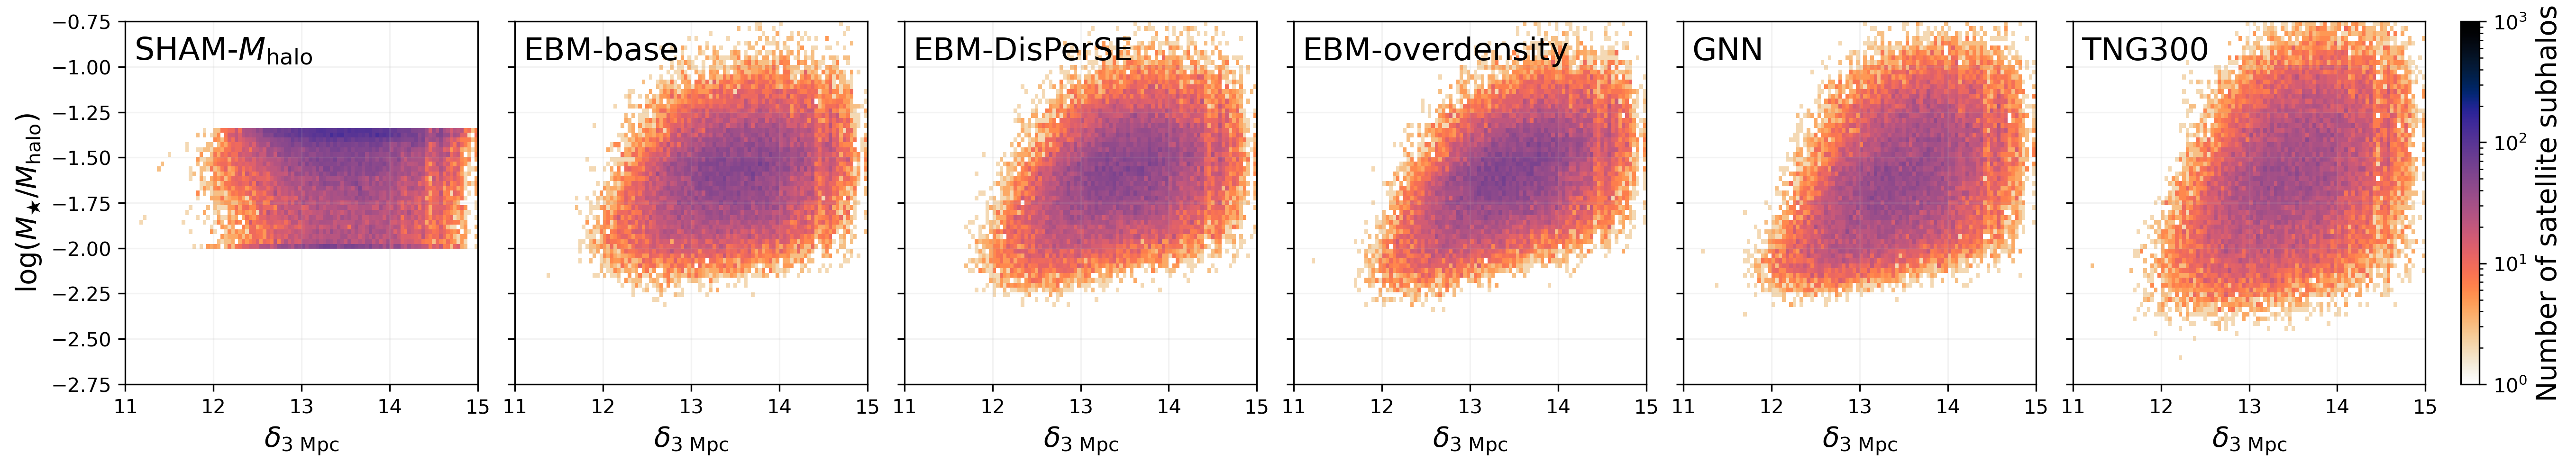

In [110]:
fig = plt.figure(figsize=(18, 3.2), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(1, 6, wspace=0.02, left=0.025, right=0.925, bottom=0.06, top=0.975, )
axes = gs.subplots(sharey="row")

ax0, ax1, ax2, ax3, ax4, ax5 = axes

hist2d_kwargs = dict(range=[(11, 15), (-2.75, -0.75)], bins=[100, 75], cmap=cmr.torch_r, norm=matplotlib.colors.LogNorm(vmin=1, vmax=1e3), rasterized=True)
df = Query("is_central == False").filter(df_with_sham)

ax0.hist2d(df.overdensity, df.p_sham_mhalo - df.log_Mhalo_dmo, **hist2d_kwargs)
ax0.text(0.025, 0.96, f"SHAM-$M_{{\\rm halo}}$", va="top", transform=ax0.transAxes, fontsize=16)

ax1.hist2d(df.overdensity, df.p_EBM_base - df.log_Mhalo_dmo, **hist2d_kwargs)
ax1.text(0.025, 0.96, f"EBM-base", va="top", transform=ax1.transAxes, fontsize=16)

ax2.hist2d(df.overdensity, df.p_EBM_disperse - df.log_Mhalo_dmo, **hist2d_kwargs)
ax2.text(0.025, 0.96, f"EBM-DisPerSE", va="top", transform=ax2.transAxes, fontsize=16)

ax3.hist2d(df.overdensity, df.p_EBM_overdensity - df.log_Mhalo_dmo, **hist2d_kwargs)
ax3.text(0.025, 0.96, f"EBM-overdensity", va="top", transform=ax3.transAxes, fontsize=16)

ax4.hist2d(df.overdensity, df.p_GNN_dmo - df.log_Mhalo_dmo, **hist2d_kwargs)
ax4.text(0.025, 0.96, f"GNN", va="top", transform=ax4.transAxes, fontsize=16)

_, _, _, h = ax5.hist2d(df.overdensity, df.log_Mstar - df.log_Mhalo_dmo, **hist2d_kwargs)
ax5.text(0.025, 0.96, f"TNG300", va="top", transform=ax5.transAxes, fontsize=16)

cb = fig.colorbar(h, ax=axes, pad=0.01, shrink=1.)
cb.set_label("Number of satellite subhalos", fontsize=14)


for ax in axes:
    ax.grid(alpha=0.15)

    if ax == axes[0]:
        ax.set_ylabel("log($M_{\\bigstar}/M_{\\rm halo}}$)", fontsize=14)
    ax.set_xlabel("$\\delta_{3\ \\rm Mpc}$", fontsize=14)

plt.savefig(f"{results_base_path}/SHMR-overdensity-satellites.pdf")

# Appendix Table: GNN details